In [1]:
# import
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('C:/Users/Admin/Desktop/Python_koda')
from scipy.optimize import curve_fit
import sympy as sym
import scipy as sc
#import pandas as pd
import numpy.random as rndm
#from numpy.random import random as RND
from numpy.random import uniform as UNFM
#from numpy.random import randint 
#from matplotlib.animation import FuncAnimation
import time

import scienceplots
plt.style.use(['science','notebook','grid'])

In [95]:
#%% XCOM - data for absoprtion coefficient of lead (82-Pb)
   # MAC = Mass Absorption Coefficient
E_gamma, MAC_coh, MAC_compton, MAC_fe, MAC_tp_jedro, MAC_tp_el, MAC_tot, MAC_wo_coh = [],[], [],[],[],[], [],[]
with open('C:/Users/Admin/Desktop/MAGISTERIJ/4. semester/ZF - zdravstvnea_fizika/simulacije/1-Bulid-up faktor/attenuation_coefficient_Lead.txt','r') as file:
    for vrstica in file:
        vrstica = vrstica.split()
        #print(vrstica[0])
        E_gamma.append(float(vrstica[0]))
        MAC_coh.append(float(vrstica[1]))
        MAC_compton.append(float(vrstica[2]))
        MAC_fe.append(float(vrstica[3]))
        MAC_tp_jedro.append(float(vrstica[4]))
        MAC_tp_el.append(float(vrstica[5]))
        MAC_tot.append(float(vrstica[6]))
        MAC_wo_coh.append(float(vrstica[7]))
E_gamma,MAC_coh,MAC_compton,MAC_fe = np.array(E_gamma), np.array(MAC_coh),np.array(MAC_compton),np.array(MAC_fe)
MAC_tp_jedro,MAC_tp_el,MAC_tot,MAC_wo_coh = np.array(MAC_tp_jedro),np.array(MAC_tp_el),np.array(MAC_tot),np.array(MAC_wo_coh)

   # AC = Absorption Coefficient  [1/cm]
Pb_density = 11.35 # cm^2/g
AC_coh,AC_compton,AC_fe = Pb_density*MAC_coh, Pb_density*MAC_compton, Pb_density*MAC_fe
AC_tp_jedro,AC_tp_el,AC_tot,AC_wo_coh = Pb_density*MAC_tp_jedro, Pb_density*MAC_tp_el, Pb_density*MAC_tot, Pb_density*MAC_wo_coh

  # skupen presek za tvorbo parov! 
AC_tp = AC_tp_jedro + AC_tp_el
#AC_tp_jedro
#AC_tp/AC_tp_jedro

num = 54
print(AC_tp[num]/AC_compton[num])
print(E_gamma[num])



1.0898731041456018
5.0


In [96]:
#%% CHATgpt INTERPOLATION (energijska interpolacija abs koeficientov)
def AC_interpolation(E0, E, AC):
    """
    Linearly interpolates the absorption coefficient at energy E0.
    Parameters:
        E0 (float): The energy at which to determine the absorption coefficient.
        E (array-like): Array of energies (must be in ascending order).
        AC (array-like): Array of absorption coefficients corresponding to the energies in E.
    Returns:
        float: Interpolated absorption coefficient at energy E0.
    """
    # Find the index where E0 should be inserted
    index = np.searchsorted(E, E0, side='right') - 1
    # If E0 is outside the range of E, return the absorption coefficient at the closest energy
    if index < 0:
        return AC[0]
    elif index >= len(E) - 1:
        return AC[-1]
    # če je genau ena od tableiranih energij (predvsem če začetno energijo tko izbereš...
    elif E[index] == E0:
        #print('genau')
        return AC[index]
    
    # Perform linear interpolation
    x0, x1 = E[index], E[index + 1]
    y0, y1 = AC[index], AC[index + 1]
    if y1 == 0:
        #return 'Non-existing process'
        return 0 
    return y0 + (y1 - y0) * (E0 - x0) / (x1 - x0)

# Example usage 
#E = np.array([1, 2, 3, 4, 5])
#AC = np.array([0.5, 0.7, 0.9, 1.2, 1.5])
#E0 = 2
# Interpolate the absorption coefficient at energy E0
#interpolated_AC = AC_interpolation(E0, E, AC)
#print("Interpolated absorption coefficient at energy", E0, "is:", interpolated_AC)

# primer iz xcom podatkov 
E0 = 0.1
interpolated_AC = AC_interpolation(E0, E_gamma, AC_tot)
print(interpolated_AC)
#print("Interpolated absorption coefficient at energy", E0, "MeV is:", interpolated_AC, '/cm')
#E_gamma[np.searchsorted(E_gamma,E0,side='right')-1]
#AC_tot[np.searchsorted(E_gamma,E0,side='right')-1]

#print(AC_tp_jedro)
#AC_interpolation(0.4,E_gamma,AC_tp_jedro)

62.98115


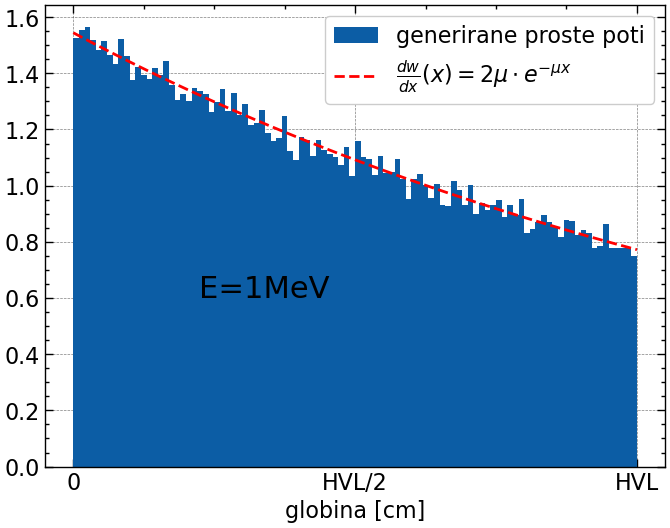

In [97]:
#%% interaction length generator
def InteractionLength(E0,E,AC):
    # returns interaction length of E0 energetic gamma, using interpolation data for 
    # determing ac and exponentil PDF for interaction lengths!
    ac = AC_interpolation(E0,E,AC)
    # če ni interakcije    
    if ac == 0:
        return 10**15
    s_int = - np.log(UNFM()) / ac
    return s_int

#InteractionLength(0.1,E_gamma,AC_tp)

# manipulate ac - different pdf - but this is unnecessary (can just multiply normally drawn s_free by same factor!!)
def InteractionLengthManipulated(E0,E,AC,reduction_factor=1):
    # returns interaction length of E0 energetic gamma, using interpolation data for 
    # determing ac and exponentil PDF for interaction lengths!
    ac = AC_interpolation(E0,E,AC) / reduction_factor
    # če ni interakcije    
    if ac == 0:
        return 10**15
    s_int = - np.log(UNFM()) / ac
    return s_int

def InteractionLengthWithWeights(E0,E,AC):
    ac = AC_interpolation(E0,E,AC)
    if ac == 0:
        return 10**15
    s_int = - np.log(1 - UNFM()/2) / ac
    return s_int

# test
E0 = 1
int_lengths = [InteractionLengthWithWeights(E0,E_gamma,AC_wo_coh) for _ in range(10**5)]
plt.hist(int_lengths,bins=100, density=True,label = 'generirane proste poti')
ac = AC_interpolation(E0,E_gamma,AC_wo_coh)
HVL = np.log(2) / ac

x = np.linspace(0,np.log(2)/ac,100)
dwdx = 2 * ac * np.exp(-ac*x) 
plt.plot(x,dwdx,'r--',label = r'$\frac{dw}{dx} (x) = 2 \mu \cdot e^{-\mu x}$') #color='orange')
plt.xlabel('globina [cm]')        
plt.text(0.2,0.6,s='E=1MeV',fontsize=22)        
plt.xticks([0,HVL/2,HVL],[0,'HVL/2','HVL'])
#plt.gca().xaxis.set_tick_params(which='both', length=6, width=2)        
#plt.tick_params(axis='x', which='both', bottom=True, top=True)
        
        
plt.legend()
plt.show()


In [98]:
#%% (x,y,z) <-> (phi,theta): 
# a) caterzian to spherical
def Cartesian_to_spherical(omega):
       # kero uzet ??
    x,y,z = omega  # ok just stupid, should be direction and omega=(th,phi)
    #x,y,z = omega + np.array([1/10**13 for _ in range(3)])
    r = np.sqrt(x**2 + y**2 + z**2)
    phi = np.arccos(z / r)
    theta = np.arctan2(y, x)
    if theta<0:
        theta += 2*np.pi
    return theta, phi

#omega = (1,1/10**13,1/10**13)
omega = np.array([1,0,0])
print(Cartesian_to_spherical(omega))

   # kle so ble težave, morš dodat +2*pi, če theta<0 ...
omega = [0.869,-0.127,-0.479]
print(Cartesian_to_spherical(omega))

# Example usage
#omega = (1, 1, 1) # Example direction vector
#omega = (0.869,-0.127,-0.479)
#PHI, THETA = Cartesian_to_spherical(omega)
#print("Polar angle (PHI):", PHI)
#print("Azimuthal angle (THETA):", THETA)


#%%  b) spherical to cartesian
def Spherical_to_cartesian(direction):
    theta, phi = direction
    #Sphi = np.sin(phi) if np.sin(phi) 
    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)
    
    return np.array([x,y,z])   
    #omega = np.array([x,y,z]) + np.array([1/10**13 for _ in range(3)])
    #return omega

#omega = (1,1,10)
#Cartesian_to_spherical(omega)
dir = (np.pi/2+10**(-13),10**(-13))
dir = (10**(-13),np.pi/2+10**(-13))
Spherical_to_cartesian(dir)

#dir = (np.pi/2, np.pi)
dir = (0, np.pi/2)
dir = Cartesian_to_spherical([1,0,0])
Spherical_to_cartesian(dir)

-np.array(dir)
dir  = np.array(dir)
a,b = dir
b

(0.0, 1.5707963267948966)
(6.138067651794184, 2.070112168918336)


1.5707963267948966

In [99]:
#%% path to exit of cuboid
def PathToExit(d,a,b,r0,direction):
      # location
    x0,y0,z0 = r0 
    #x0,y0,z0 = r0 + np.array([1/10**13 for _ in range(3)])

    #if x0<0 or x0>d or y0<-a/2 or y0>a/2 or z0<-b/2 or z0>b/2:
     #   return 'Wrong R0'

    ploskve = []
    # ploskve označimo s število 0-5, 0 = leva ploskev, 1=desna ploskev (obe 
    # pravokotni na os x), 2 = sprednja y, 3= zadnja y, 4=spodnja z, 5=zgornja z
    
      # direction: theta, phi --> omega
    theta, phi = direction
    omega = Spherical_to_cartesian(direction)
    
    if theta < np.pi/2 or theta > 3/2 * np.pi:
        # proti desni x ploskvi
        lam_x = 1/omega[0] * (d - x0)
        ploskve.append(1)
    else:
        # proti levi x ploskvi - tu tudi vstopa
        lam_x = 1/omega[0] * (-x0)
        ploskve.append(0)
    if theta < np.pi:
        # proti zgornji y ploskvi
        lam_y = 1/omega[1] * (a/2 - y0)
        ploskve.append(3)
    else:
        lam_y = 1/omega[1] * (-a/2 - y0)
        ploskve.append(2)
    if phi < np.pi/2:
        lam_z = 1/omega[2] * (a/2 - z0)
        ploskve.append(5)
    else:
        lam_z = 1/omega[2] *(-a/2 - z0)
        ploskve.append(4)
    LAM = [lam_x,lam_y,lam_z]
    #LAM = [abs(l) if abs(l)>10**3 for l in LAM else l for l in LAM]
    lam_min = min(LAM)
    ind_lam = LAM.index(lam_min)
    ind_ploskev = ploskve[ind_lam]
    #return ploskve,LAM,lam_min, ind_ploskev
    return lam_min, ind_ploskev

  # začetni pogoj - vstop fotona v svinec / poljubna smer
 # če vstopa v svinec, morš dat neničelni vredosti za omega(y in z) (se izkaže ...) 
R0 = [0,0,0]
omega = np.array([1,1/10**13,1/10**13])
dir = Cartesian_to_spherical(omega)
#dir = [0,np.pi/2]
PathToExit(10,20,20,R0,dir)


   # ostalo ...
#R0 = [0.0001,0,0]
#dir = [np.pi/2+0.001,0.00001]
#R0 = [6.93,0.43,-1.50]
   # težave z negativnimi vrednostmi
#dir = [-0.145,2.07]  # morš dodat 2pi za theto
#dir = [-0.145+2*np.pi,2.07]
#PathToExit(10,20,20,R0,dir)

(10.0, 1)

In [100]:
#%% Compton energy generator
def ComptonEnergyGenerator(E):
    alfa = E / 0.511   # MeV
    e_min = 1/(1+2*alfa)
    M1, M2 = 1/2 * (1-e_min**2), -np.log(e_min)
    while True:
        u1,u2,u3 = UNFM(), UNFM(), UNFM()
        if u1 > M1/(M1+M2):
            e_proposed = e_min * np.exp(M2*u2)
        else:
            e_proposed = np.sqrt(e_min**2 + 2*M1*u2)
        f = (1-e_proposed)/alfa/e_proposed
        h= 1 - e_proposed/(1+e_proposed**2) * f * (2-f)
        if u3 < h:
            return e_proposed


In [101]:
#%%  Compton: premik smeri
def X_RotationMatrix(vec):
    # returns R = rotation matrix that rotates vector to ex vector: ex = R*vec
    # Normalize the given vector
    vec_norm = vec / np.linalg.norm(vec)
    # Calculate the axis of rotation
    axis = np.cross(vec_norm, [1, 0, 0])
    axis_norm = axis / np.linalg.norm(axis)
    # Calculate the angle of rotation
    angle = np.arccos(np.dot(vec_norm, [1, 0, 0]))
    # Construct the rotation matrix
    c = np.cos(angle)
    s = np.sin(angle)
    t = 1 - c
    x, y, z = axis_norm
    R = np.array([[t*x**2 + c, t*x*y - z*s, t*x*z + y*s],
                  [t*x*y + z*s, t*y**2 + c, t*y*z - x*s],
                  [t*x*z - y*s, t*y*z + x*s, t*z**2 + c]])
    return R

def DirectionAfterCompton(direction,th_cs,phi_cs):
    # returns 
    th, phi = direction
    omega = np.array([np.sin(phi)*np.cos(th),np.sin(phi)*np.sin(th),np.cos(phi)])
    R = X_RotationMatrix(omega)
    R_inv = np.linalg.inv(R)
      # rotacijski vektor - glede na mojo geometirjo sipanja, glej liste!!!!!
    rotation_vec = np.array([np.cos(th_cs),np.sin(th_cs)*np.cos(phi_cs), np.sin(th_cs)*np.sin(phi_cs)])
    new_direction =  np.dot(R_inv,rotation_vec)
    return new_direction/np.linalg.norm(new_direction)
    #return new_direction

#### A BI LAH DELOU U SFERIČNI GEOMETRIJI??? ... zdi se, da bi ble velke frke pri 
# ugotavljanju, skos kero ploskev je pobegnu ... za svinčeno kroglo okol točkastega
# izvira bi blo pa lepo... ni treba rotirat, samo seštevaš kote!!

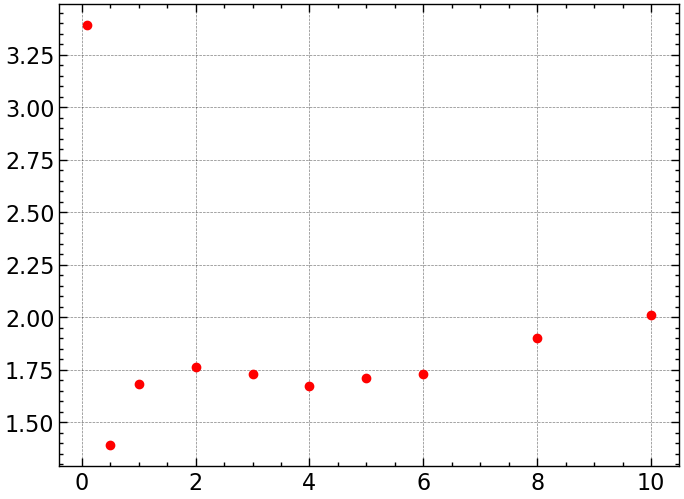

In [102]:
#%%  build-up data from Martin book
   # file:///C:/Users/Admin/Desktop/MAGISTERIJ/3.%20Semester/FNJN/literatura/2013-Martin-Physics_for_radiation_protection-edition_3.pdf
  # str 326 - Pb
  
# thicknesses and incident energies are universal (for all materials)
thicknesses = np.array([0.5,1,2,3, 4, 5,6,7,8,10,15,20,25,30])  # Thicknesses of lead shield
incident_energies = np.array([0.1,0.5,1,2,3,4,5,6,8,10])

  # B_table for lead
   #### TO JE ZA TOČKAST IZVOR in ..??.. geometrijo !!!
B_Pb = np.array([
    [1.51,1.14,1.2,1.21,1.23,1.21,1.25,1.26,1.3,1.28],  # debelina = 0.5mfp
    [2.04,1.24,1.38,1.4,1.4,1.36,1.41,1.42,1.51,1.51],  # debelina = 1mpf
    [3.39,1.39,1.68,1.76,1.73,1.67,1.71,1.73,1.9,2.01],
    [5.6,1.52,1.95,2.14,2.1,2.02,2.05,2.08,2.36,2.63],
    [9.59,1.62,2.19,2.52,2.5,2.4,2.44,2.49,2.91,3.42],
    [17,1.71,2.43,2.91,2.93,2.82,2.88,2.96,3.59,4.45],
    [30.6,1.8,2.66,3.32,3.4,3.28,3.38,3.51,4.41,5.73],
    [54.9,1.88,2.89,3.74,3.89,3.79,3.93,4.13,5.39,7.37],
    [94.7,1.95,3.1,4.17,4.41,4.35,4.56,4.84,6.58,9.44],
    [294,2.1,5.51,5.07,5.56,5.61,6.03,6.61,9.73,15.4],
    [5800,2.39,4.45,7.44,8.91,9.73,11.4,13.7,25.1,50.8],
    [1.33*10**5,2.64,5.27,9.98,12.9,15.4,19.9,26.6,62,161],
    [3.34*10**6,2.85,5.98,12.6,17.5,23,32.9,49.6,148,495],
    [8.9*10**7,3.02,6.64,15.4,22.5,32.6,52.2,88.9,344,1470],  # debelina = 30 mfp
    ])

# function for searching B = B(d,E0) 
def B_Martin(d,E,B_table):
    if d not in thicknesses or E not in incident_energies:
        return 'Error: wrong d/E'
    d_ind = np.where(thicknesses==d)[0][0]
    E_ind = np.where(incident_energies==E)[0][0]
    return B_table[d_ind,E_ind]

# example
B_Martin(d=2,E=8,B_table=B_Pb)
#print(B_Martin(d=0.5,E=incident_energies,B_table=B_Pb))

# plot
d_plot = thicknesses[2]
B_values = [B_Martin(d_plot,E,B_Pb) for E in incident_energies]
B_values
plt.plot(incident_energies,B_values,'ro')
#def MartinPlot(E_array,d):
 #   for E in E_array
  #  plt.plot()



In [103]:
#%% testiranje simulacijske kode  (brez tvorbe parov)
def PhotonSimulationTest(E0,N_simulated,cuboid,E_min):
    d, a, b = cuboid
    E_out = np.zeros(6)  # matrika, ki zbira, koliko energije zapusti Pb v določeni ploskvi
    E_abs = 0    # absorbed energy
    interactions = ['compton','fe']  # tipi interakcij, ki jih upoštevamo
    #ac_fe, ac_compton = 
    for i in range(N_simulated):
        # foton: E_current, r0, direction=(phi,theta) [KJE JE, KAM GRE, kakšno energijo ima]
        E_current = E0  # trenutna energija fotona
        # začetni položaj in smer
        r0 = np.array([1/10**15,0,0]) # začetna lokacija = (0,0,0)
        omega = np.array([1,1/10**13,1/10**13])  # začetna smer
        direction = Cartesian_to_spherical(omega)  # = (theta, phi)
        # šteješ interakcije enega fotona
        j = 0        
        print(f'\n------------- foton # {i+1}----------')
        
        while True:    
            # možna dolžina poti in ploskev izstopa
            lam, ploskev = PathToExit(d,a,b,r0,direction)
            #print(f'lam={lam} (r0={r0},dir={direction})')
            
            # dolžina proste poti in interakcija
            s_com, s_fe = InteractionLength(E_current,E_gamma,AC_compton), InteractionLength(E_current,E_gamma,AC_fe)
            s_int, int_type = min(s_com,s_fe), interactions[np.argmin([s_com,s_fe])]
            
            # gre foton ven ali interagira?
            if s_int > lam:
                print(f'\n   ---escape---\ns_int={s_int}>{lam}=lam; (#pl={ploskev})')
                E_out[ploskev] += E_current
                print(f'E_out = {E_current}')
                break
            else:
                # prišteješ interakcijo
                j += 1
                # fotoefekt ali prenizka energija -> ABSORPCIJA
                if int_type == 'fe' or E_current<E_min:
                    print(f'\n   ------photoefect-(interaction #{j})-------')
                    print(f's_int={s_int}<{lam}=lam')
                    E_abs += E_current
                    print(f'E_abs={E_current}')
                    break
                # Comptonsko sipanje -> sprememba r0, E_current, smer=direction
                elif int_type == 'compton':                    
                    print(f'\n   -----compton-(interaction #{j})---')
                    print(f's_int={s_int}<{lam}=lam')
                    #print(f'r0={r0}; dir={direction[0]*180/np.pi,direction[1]*180/np.pi}')
                    #print(omega)
                    r0 += omega * s_int
                    eps = ComptonEnergyGenerator(E_current)
                    print(f'eps={eps}')
                    E_abs += E_current * (1-eps)
                    E_current *= eps
                    th_cs = np.arccos(1 - (1-eps)/(a*eps))
                    phi_cs = UNFM(0,2*np.pi)
                    print(f'th_cs,phi_cs={th_cs*180/np.pi,phi_cs*180/np.pi}')
                    
                    # nova smer 
                    omega = DirectionAfterCompton(direction,th_cs,phi_cs)                    
                    direction = Cartesian_to_spherical(omega)
                    print(f'omega={omega}')
                    print(f'r0_new={r0}; dir_new={direction[0]*180/np.pi,direction[1]*180/np.pi}')
                    
    return E_out, E_abs 


## povprečna prosta pot pri določeni energiji
E0 = 5  # MeV
ac = AC_interpolation(E0,E_gamma,AC_tot)
print(f'mfp={1/ac} cm')
ac_com = AC_interpolation(E0,E_gamma,AC_compton)
print(f'mfp_com={1/ac_com} cm')
ac_fe = AC_interpolation(E0,E_gamma,AC_fe)
print(f'mfp_fe={1/ac_fe} cm')

   # simulacija z analizo/sledenjem delcem
np.random.seed(76490)
PhotonSimulationTest(E0=5,N_simulated=10,cuboid=(5,20,20),E_min=E_gamma[0])

mfp=2.0623999736012806 cm
mfp_com=4.4542834616909355 cm
mfp_fe=69.75908699306943 cm

------------- foton # 1----------

   -----compton-(interaction #1)---
s_int=3.926279050338931<4.999999999999999=lam
eps=0.3073979277909103
th_cs,phi_cs=(27.45858308325433, 285.9214718554265)
omega=[ 0.88734438  0.12649078 -0.44341857]
r0_new=[3.92627905e+00 3.92627905e-13 3.92627905e-13]; dir_new=(8.112845322235819, 116.32220384077553)

   ---escape---
s_int=3.387714564995031>1.2100385958027886=lam; (#pl=1)
E_out = 1.5369896389545514

------------- foton # 2----------

   ---escape---
s_int=10.352062500650385>4.999999999999999=lam; (#pl=1)
E_out = 5

------------- foton # 3----------

   -----compton-(interaction #1)---
s_int=1.8098910032315785<4.999999999999999=lam
eps=0.135809718649389
th_cs,phi_cs=(47.012574556164694, 275.52352625799006)
omega=[ 0.68183784  0.07041046 -0.72810681]
r0_new=[1.809891e+00 1.809891e-13 1.809891e-13]; dir_new=(5.895791109085902, 136.72791552124062)

   -----compton-(inte

(array([ 0.        , 25.83221597,  0.        ,  0.        ,  0.        ,
         0.        ]),
 24.167784028988226)

In [104]:
#%%  povprečna prosta pot pri določeni energiji
print('---MFP = mean free paths----')
E0 = .01   # MeV
print(f'    -----E={E0} MeV------')
   # total
ac = AC_interpolation(E0,E_gamma,AC_tot)
print(f'mfp={1/ac} cm')
   # total wo coherent
ac_wo_coh = AC_interpolation(E0,E_gamma,AC_wo_coh)
print(f'mfp_wo_coh={1/ac_wo_coh} cm')
   #1 fotoefekt
ac_fe = AC_interpolation(E0,E_gamma,AC_fe)
print(f'mfp_fe={1/ac_fe} cm')
   #2 compton
ac_com = AC_interpolation(E0,E_gamma,AC_compton)
print(f'mfp_com={1/ac_com} cm')
   # compton + FE
#ac_com = AC_interpolation(E0,E_gamma,AC_compton)
print(f'mfp_com+fe={1/(ac_com+ac_fe)} cm')
   # 3tvorba parov
ac_tp_jedro = AC_interpolation(E0,E_gamma,AC_tp_jedro)
mfp_tp = 1/ac_tp_jedro if ac_tp_jedro !=0 else 'inf (non-existing)'
print(f'mfp_tp={mfp_tp} cm')
   # 4coherent
ac_coh = AC_interpolation(E0,E_gamma,AC_coh)
print(f'mfp_coh={1/ac_coh} cm')

print(E_gamma[0])

---MFP = mean free paths----
    -----E=0.01 MeV------
mfp=0.0006746227172453805 cm
mfp_wo_coh=0.0007009206592859721 cm
mfp_fe=0.0007014787171357222 cm
mfp_com=1.9406547769217333 cm
mfp_com+fe=0.0007012252487735062 cm
mfp_tp=inf (non-existing) cm
mfp_coh=0.017684810692943937 cm
0.001


In [105]:
#%% prva interakcija žrebaš posebej - primerno za tanke sloje Pb

In [106]:
#%% kohenetno sipanje ??
 
  #  Attix str. 153 ...

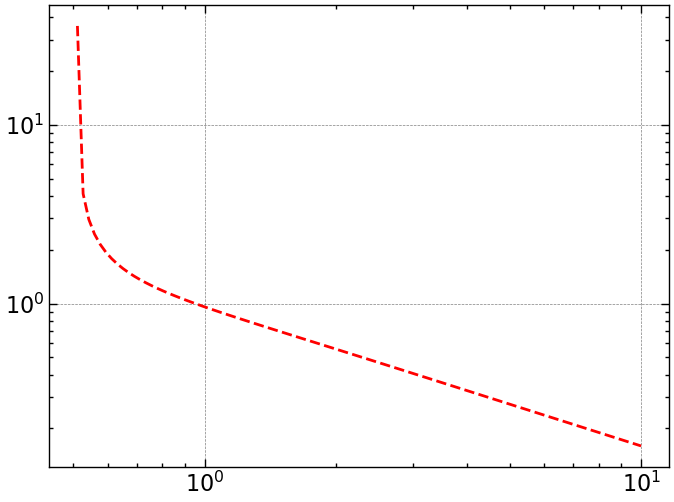

In [107]:
#%% Analiza preseka za TP v odv od energije
   # file:///C:/Users/Admin/Desktop/MAGISTERIJ/4.%20semester/ZF%20-%20zdravstvnea_fizika/simulacije/1-Bulid-up%20faktor/annihilation_cross-section.pdf 
def AnnihilationCrossSection(E):
    # E  total positron energy
    #if E<0.511:
     #   return 'error: wrong energy'
    y = E/0.511
    f1 = (y**2+4*y+1)/(y**2-1) * np.log(y + np.sqrt(y**2-1))
    f2 = (y+3) / (np.sqrt(y**2-1))
    return 1/ (y+1) * (f1 - f2)

 # tale graf je že dost poveden
E_min = [0.5112,0.512,0.52][0] 
E_max = [0.52,0.55,0.6,0.7,1,2,5,10][-1] 
PositronEnergy = np.geomspace(E_min, E_max, 100)
Heitler = AnnihilationCrossSection(PositronEnergy)
plt.loglog(PositronEnergy,Heitler, 'r--')
 
 # loglog
#PositronEnergy = np.geomspace(0.512, 30, 100)
#Heitler = AnnihilationCrossSection(PositronEnergy)
#plt.loglog(PositronEnergy,Heitler, 'ro')

In [108]:
#%% kolikšna bo energija pozitrona pri anihilaciji?
#path = 'C:/Users/Admin/Desktop/MAGISTERIJ/4. semester/ZF - zdravstvnea_fizika/simulacije/1-Bulid-up faktor'
#sys.path.append(path) ## S poševnicami v desno!!!  ///   !!!
#from build_up import FuncNorm

# AnnihilationCrossSection(E=10)
# E0 = .75  # začetna energija fotona
# E_min = 0.511001   # min energija pozitrona
# C_norm = FuncNorm(AnnihilationCrossSection,E_min,E0)
# C_norm
# AnnihIntegral = 1 / C_norm

# AnnihPropPartition = lambda E: sc.integrate.quad(AnnihilationCrossSection,E_min,E)
 
# E_max = .55 
# IntPart = AnnihPropPartition(E_max)[0]
# print(IntPart, AnnihIntegral)

   #### ZANIMIVO, KAŽE KOT DA JE VELIKA ŠANSA, DA SE POZITRON ANIHILIRA V LETU, IN TO
   ### PRI ZNATNI ENERGIJI, pri FFMS smo rekli E_positron ~ 20 eV @ annihilation; which 
   ## coresponds to angle offset 0.5°, skripta str. 165 !!!!!!!!!!
### odgovor: sm prsu do sklepa, s pomocjo siskusije s chatgptjem, ampak se mi je ideja sama
# povsetila: simpl je, nima veze presek, se vedno je interakcija mnogo manj verjetna od 
# iterakcije pozitrona z elektroni v snovi, pozitron se ustavi tipicno MNOGO prej kakor
# dozivi interakcijo anihilacija (recimo v 10^5 krat manjsem casu!!). Sprva se takoj ustavi
# nato lebdi v snovi z neko termicno energijo in se mnogo kasnej anihilira z enim elektronom!!
  # kul

In [109]:
#%% simulacjska koda - s tvorbo parov! (se da boljš? - z eno fjo recmo...)
def PhotonSimulationAnd_PP_Production(E0,N_simulated,cuboid,E_min,beam_type='point'):
     # dodamo še produkcijo parov
    #if E0 < 1.023:
        #return 'E0 to small'
    # dimenzije svinčenega kvadra
    d, a, b = cuboid
    # parameter alfa
    alfa0 = E0/0.511
    # ''tallies''
    E_out = np.zeros(6)  # matrika, ki zbira, koliko energije zapusti Pb v določeni ploskvi
    E_abs = 0    # absorbed energy
    interactions = ['compton','fe','tp']  # tipi interakcij, ki jih upoštevamo
    directions_tp = []
    locations_tp = []
    N_esc,N_fe,N_com,N_pp =0, 0, 0, 0
    for i in range(N_simulated):
        # začetna energija, lega in smer
        # foton-karakteriskike: E_current, r0, direction=(phi,theta) [KJE JE, KAM GRE, kakšno energijo ima]
        if beam_type == 'point':
            r0 = np.array([float(0),0,0]) # začetna lokacija = (0,0,0)
        elif beam_type == 'plane':
            r0 = np.array([float(0),UNFM(-a/2,a/2),UNFM(-b/2,b/2)])
        else:
            return 'error: wrong beam type'
        omega = np.array([1,1/10**13,1/10**13])  # začetna smer
        #direction = (0,np.pi/2) # = (theta, phi) 
        direction = Cartesian_to_spherical(omega)  # = (theta, phi)
        E_current = E0  # trenutna energija fotona 
        alfa_current = E0 / 0.511
        int_tp = 0
        
        while True:    
            # možna dolžina poti in ploskev izstopa
            lam, ploskev = PathToExit(d,a,b,r0,direction)
            
            # dolžina proste poti in interakcija
            s_com, s_fe, s_tp = InteractionLength(E_current,E_gamma,AC_compton), \
            InteractionLength(E_current,E_gamma,AC_fe), InteractionLength(E_current,E_gamma,AC_tp)
            s_int, int_type = min(s_com,s_fe, s_tp), interactions[np.argmin([s_com,s_fe,s_tp])]
            
            # gre foton ven ali interagira?
            if s_int > lam:
                E_out[ploskev] += E_current
                if E_current == E0:
                    N_esc += 1
                break
            else:
                
                # fotoefekt ali prenizka energija -> ABSORPCIJA
                if int_type == 'fe' or E_current<E_min:
                    E_abs += E_current
                    N_fe += 1
                    break
                # Comptonsko sipanje -> sprememba r0, E_current, smer=direction
                elif int_type == 'compton':                    
                    N_com += 1
                    # eps = E'/E, comptonska kota
                    eps = ComptonEnergyGenerator(E_current)
                    th_cs = np.arccos(1 - (1-eps)/(alfa_current*eps))
                    phi_cs = UNFM(0,2*np.pi)
                    # nov položaj, energija in abs energija                
                    r0 += omega * s_int
                    E_abs += E_current * (1-eps)
                    E_current *= eps
                    alfa_current *= eps
                    # nova smer
                    omega = DirectionAfterCompton(direction,th_cs,phi_cs)                    
                    direction = Cartesian_to_spherical(omega)                    
                elif int_type== 'tp':
                    N_pp += 1
                    E_abs += E_current - 1.022
                    r0 += omega * s_int
                    E_current = 0.511 
                    direction = (UNFM(0,2*np.pi), np.arccos(2*UNFM()-1))
                    omega = Spherical_to_cartesian(direction)
                    alfa_current = 1
                    # zbiranje podatkov za novo simulacijo anihilacijskih žarkov
                    dir0 = direction[0] + np.pi if direction[0]<np.pi else direction[0] - np.pi
                    dir1 = np.pi - direction[1]
                    directions_tp.append([dir0,dir1])
                    locations_tp.append(r0)
                    
    N_int = np.array([N_fe,N_com,N_pp,N_esc])
    return E_out, E_abs, np.array(directions_tp), np.array(locations_tp) #, N_int

#np.random.seed(1238)
#N_simulated = 1
#PhotonSimulation(E0,N_simulated,cuboid,E_min=E_gamma[0])

    ##  2. anihilacijski fotoni -dodatna simulacija (znam boljše??)
def AnnihilationPhotonSimulation(locations,directions,cuboid,E_min):
    # dimenzije svinčenega kvadra
    d, a, b = cuboid
    # parameter alfa
    alfa0 = E0/0.511
    # ''tallies''
    E_out = np.zeros(6)  # matrika, ki zbira, koliko energije zapusti Pb v določeni ploskvi
    E_abs = 0    # absorbed energy
    interactions = ['compton','fe']  # tipi interakcij, ki jih upoštevamo
    #N_esc,N_fe,N_com,N_pp =0, 0, 0, 0
    for i in range(len(locations)):
        # foton-karakteriskike: E_current, r0, direction=(phi,theta) [KJE JE, KAM GRE, kakšno energijo ima]
        r0 = locations[i] # začetna lokacija
        direction = directions[i]
        omega = Spherical_to_cartesian(direction)  # začetna smer
        E_current = 0.511 # trenutna energija fotona 
        alfa_current = 1
        
        while True:    
            # možna dolžina poti in ploskev izstopa
            lam, ploskev = PathToExit(d,a,b,r0,direction)
            
            # dolžina proste poti in interakcija
            s_com, s_fe = InteractionLength(E_current,E_gamma,AC_compton), \
            InteractionLength(E_current,E_gamma,AC_fe)
            s_int, int_type = min(s_com,s_fe), interactions[np.argmin([s_com,s_fe])]
            
            # gre foton ven ali interagira?
            if s_int > lam:
                E_out[ploskev] += E_current
                #if E_current == E0:
                    #N_esc += 1
                break
            else:
                
                # fotoefekt ali prenizka energija -> ABSORPCIJA
                if int_type == 'fe' or E_current<E_min:
                    E_abs += E_current
                    #N_fe += 1
                    break
                # Comptonsko sipanje -> sprememba r0, E_current, smer=direction
                elif int_type == 'compton':                    
                    #N_com += 1
                    # eps = E'/E, comptonska kota
                    eps = ComptonEnergyGenerator(E_current)
                    th_cs = np.arccos(1 - (1-eps)/(alfa_current*eps))
                    phi_cs = UNFM(0,2*np.pi)
                    # nov položaj, energija in abs energija                
                    r0 += omega * s_int
                    E_abs += E_current * (1-eps)
                    E_current *= eps
                    alfa_current *= eps
                    # nova smer
                    omega = DirectionAfterCompton(direction,th_cs,phi_cs)                    
                    direction = Cartesian_to_spherical(omega)                    
                    
    #N_int = np.array([N_fe,N_com,N_pp,N_esc])
    return E_out, E_abs   # N_int
#
   # obe zgornji fji združim v eno simulacijsko fjo!!!
def PhotonSimulationWithPP(E0,N_simulated,cuboid,E_min,beam_type='point'):
    E_out1, E_abs1, dirpp, locpp = PhotonSimulationAnd_PP_Production(E0,N_simulated,cuboid,E_min,beam_type)
    E_out2, E_abs2 = AnnihilationPhotonSimulation(locpp,dirpp,cuboid,E_min)
    return E_out1 + E_out2, E_abs1 + E_abs2






In [110]:
#%% forcing interactions - testing code with prinitng
def PhotonSimulation_forcing_interacitons_test_printing(E0,N_simulated,n_hvl,w_min=10**(-3),beam_type='point'):
    # dimenzije svinčenega kvadra - glede na hvl = ac(E0)
    ac0_total = AC_interpolation(E0,E_gamma,AC_wo_coh)
    HVL0 = np.log(2) / ac0_total
    d = n_hvl * HVL0
    a=b = 10 * HVL0
    # parameter alfa
    alfa0 = E0/0.511
    # ''tallies''
    E_out = np.zeros(6)  # matrika, ki zbira, koliko energije zapusti Pb v določeni ploskvi
    E_abs = 0    # absorbed energy
    interactions = ['compton','tp']  # tipi interakcij, ki jih upoštevamo
    directions_tp = []
    locations_tp = []
    weights_tp = []

    # counting escaped and absorbed
    n_esc, n_abs, n_tp = 0, 0, 0
    E_out_data = [] # kakšne so energije fotonov, ki pobegnejo?
    W_list = []

    # min value of the weight
    #w_min = 2**(-n_hvl) / 1000
    #w_min = 10**(-8)

    for i in range(N_simulated):
        print(f'   ----photon # {i}----')
        # začetna energija, lega in smer
        if beam_type == 'point':
            r0 = np.array([float(0),0,0]) # začetna lokacija = (0,0,0)
        elif beam_type == 'plane':
            r0 = np.array([float(0),UNFM(-a/2,a/2),UNFM(-b/2,b/2)])
        else:
            return 'error: wrong beam type'
        
        omega = np.array([1,1/10**13,1/10**13])  # začetna smer
        direction = Cartesian_to_spherical(omega)  # = (theta, phi)
        E_current = E0  # trenutna energija fotona 
        alfa_current = E0 / 0.511
        
        # index - for use in first interaction simulation
        index = 0

        while True:
            # možna dolžina poti in ploskev izstopa
            lam, ploskev = PathToExit(d,a,b,r0,direction)
            # absorption coefficitnts and weights
            ac_com, ac_fe, ac_tp = (
                AC_interpolation(E_current,E_gamma,AC_compton), 
                AC_interpolation(E_current,E_gamma,AC_fe),
                AC_interpolation(E_current,E_gamma,AC_tp)
            )
            ac_tot = ac_com + ac_fe + ac_tp 

            # free path length and interaction type - force pp and cs, ignere pe
            ## i) first interaction - forced
            if index == 0:
                while True:
                    s_int = - np.log(UNFM()) / ac_tot
                    if s_int < d:
                        break
                # start weight - force first interaction 
                weight = 1 - np.exp(-d * ac_tot)
                print(f'w={weight}; forcing first interaction')
            ## ii) next (possible) interacitons
            else:
                s_int = - np.log(UNFM()) / ac_tot            
            
            # a) does photon escape? ....
            if s_int > lam:
                n_esc += 1
                E_out_data.append(E_current)
                E_out[ploskev] += weight * E_current
                W_list.append(weight)
                print(f'ESCSAPE # {n_esc} ({weight*E_current} MeV)')
                break            

            # b) ...or does it interact? -> which interaction?
            else:
                # interaction type
                if UNFM() < ac_tp/ ac_tot:
                    n_tp += 1
                    int_type = 'tp'
                    print('->int = tp')
                else:
                    int_type = 'compton'
                    print('-> int=compton')
            
            # interaction type forcing weight ... multiplies w previous value 
            weight *= (ac_com + ac_tp) / ac_tot
            print(f'w={weight}; forcing CS/TP')
            if weight < w_min:
                print(f'ABSORPTION; weight < w_min (E_current= {E_current} MeV)')
                n_abs += 1
                break

            # I) Compton scattering -> sprememba r0, E_current, smer=direction
            if int_type == 'compton':
                index += 1                    
                # eps = E'/E, comptonska kota
                eps = ComptonEnergyGenerator(E_current)
                th_cs = np.arccos(1 - (1-eps)/(alfa_current*eps))
                phi_cs = UNFM(0,2*np.pi)
                # nov položaj, energija in abs energija                
                r0 += omega * s_int
                E_abs += E_current * (1-eps)
                E_current *= eps
                alfa_current *= eps
                # nova smer
                omega = DirectionAfterCompton(direction,th_cs,phi_cs)                    
                direction = Cartesian_to_spherical(omega)                    
            elif int_type== 'tp':
                #n_tp += 1
                index += 1
                E_abs += (E_current - 1.022)
                r0 += omega * s_int
                E_current = 0.511 
                direction = (UNFM(0,2*np.pi), np.arccos(2*UNFM()-1))
                omega = Spherical_to_cartesian(direction)
                alfa_current = 1
                # zbiranje podatkov za novo simulacijo 2. anihilacijskih žarkov
                dir0 = direction[0] + np.pi if direction[0]<np.pi else direction[0] - np.pi
                dir1 = np.pi - direction[1]
                directions_tp.append([dir0,dir1])
                locations_tp.append(r0)
                weights_tp.append(weight)

    # simulation of the rest of the annihilation photons
    n_sec_abs, n_sec_esc = 0,0
    for i in range(len(locations_tp)):
        print(f'  ---start second anihilaton photon (# {i}) ---------')
        r0 = locations_tp[i] # začetna lokacija
        direction = directions_tp[i]
        omega = Spherical_to_cartesian(direction)  # začetna smer
        E_current = 0.511 # trenutna energija fotona 
        alfa_current = 1
        weight = weights_tp[i]

        while True:    
            # možna dolžina poti in ploskev izstopa
            lam, ploskev = PathToExit(d,a,b,r0,direction)            
            # pripadajoča utež
            ac_com, ac_fe = (
                AC_interpolation(E_current,E_gamma,AC_compton),
                AC_interpolation(E_current,E_gamma,AC_fe)
            )
            ac_tot = ac_com + ac_fe
            
            # interaction length and type = compton
            s_int = - np.log(UNFM()) / ac_tot
            int_type = 'compton'
            # weight
            weight *= ac_com / ac_tot
            print(f'w={weight}; forcing CS after PP')
            if weight < w_min:
                print(f'w < w_min ({E_current} MeV)')
                n_sec_abs += 1
                break

            # photon destiny: interaction or escape?
            ## a) escape
            if s_int > lam:
                n_sec_esc += 1
                print(f'ESCAPE after PP, # {n_sec_esc}')
                E_out[ploskev] += weight * E_current
                break

            ## b) CS
            # eps = E'/E, comptonska kota
            eps = ComptonEnergyGenerator(E_current)
            th_cs = np.arccos(1 - (1-eps)/(alfa_current*eps))
            phi_cs = UNFM(0,2*np.pi)
            # nov položaj, energija in abs energija                
            r0 += omega * s_int
            E_abs += E_current * (1-eps)
            E_current *= eps
            alfa_current *= eps
            # nova smer
            omega = DirectionAfterCompton(direction,th_cs,phi_cs)                    
            direction = Cartesian_to_spherical(omega)    
    
    # buildup calculaton
    E_prim = N_simulated * E0 * 2**(-n_hvl)
    buildup = 1 + E_out[1] / E_prim

    return E_out, E_abs, buildup, [n_esc,n_abs,n_tp], \
        [n_sec_esc,n_sec_abs], E_out_data, W_list

# example
Ts = time.time()
E0 = 1
N_sim = 3
n_hvl = 7.4
w_min = 10**(-3)
print(f'  -------------------start of simulation----------')
print(f'E0={E0} MeV; n_hvl = {n_hvl} (mu*d = {np.round(n_hvl * np.log(2),3)}); N_sim={N_sim:.1e}; w_min = {w_min}')

# simulation
res = PhotonSimulation_forcing_interacitons_test_printing(E0,N_sim,n_hvl,w_min=w_min)
print(res)
E_tot = N_sim*E0
print('\n     -------------------simulation analysis----------')
print(f'E_tot = {E_tot}; E_sec_esc={res[0][1]}; E_prim = {E_tot*2**(-n_hvl)}; E_abs = {res[1]} ')
print(f'n_esc,n_abs,n_tp= {res[3]}')
#print(f'n_sec_esc,n_sec_abs = {res[4]}')
#print(f'---Check: n_sec =? n_tp: ({res[3][2]} = {res[4][1]+res[4][0]})---')
#print(np.min(res[5]) if len(res[5])>0 else 'No escaped')
#print(res[6])
print(f'B = {res[2]}')
print(f't={time.time() - Ts} s')

  -------------------start of simulation----------
E0=1 MeV; n_hvl = 7.4 (mu*d = 5.129); N_sim=3.0e+00; w_min = 0.001
   ----photon # 0----
w=0.9940792321620687; forcing first interaction
-> int=compton
w=0.7295954146972231; forcing CS/TP
-> int=compton
w=0.39754366624942544; forcing CS/TP
-> int=compton
w=0.04896046176331833; forcing CS/TP
-> int=compton
w=0.001468428938222777; forcing CS/TP
-> int=compton
w=2.8666215101704697e-05; forcing CS/TP
ABSORPTION; weight < w_min (E_current= 0.10416239007596889 MeV)
   ----photon # 1----
w=0.9940792321620687; forcing first interaction
-> int=compton
w=0.7295954146972231; forcing CS/TP
-> int=compton
w=0.17273655251518746; forcing CS/TP
-> int=compton
w=0.011968158674609384; forcing CS/TP
-> int=compton
w=0.0007879044323664088; forcing CS/TP
ABSORPTION; weight < w_min (E_current= 0.17621134078672906 MeV)
   ----photon # 2----
w=0.9940792321620687; forcing first interaction
-> int=compton
w=0.7295954146972231; forcing CS/TP
-> int=compton
w=0.0

In [111]:
#%% 1hvl code - for now non-usable

def PhotonSimulation_1HVL(E0,N_simulated,n_hvl=1,E_min=0.001,beam_type='point'):
    # start clock - simulation time measure
    T_start = time.time()
    # dimensions of cuboid-shaped shield of Pb=lead (half value layer=hvl units)
    ac0_tot = AC_interpolation(E0,E_gamma,AC_wo_coh)
    HVL0 = np.log(2) / ac0_tot
    d = n_hvl * HVL0
    if n_hvl != 1:
        print(f'Ops, code meant for 1HVL, currently using:{n_hvl} hvl')
    # how wide is the shield??
    a=b= 3* n_hvl * HVL0
    #a = b= 10*HVL0
    # ''tallies''
    E_out = np.zeros(6)  # matrix of all 6 faces of cuboid shield - collect escaped energies through each
    E_abs = 0    # absorbed energy in shield (photoeffect, scattering...)
    interactions = ['compton','fe','tp']  # interaction types, taken into consideration
    directions_tp = []
    locations_tp = []
    #N_esc,N_fe,N_com,N_pp =0, 0, 0, 0
    n_esc, n_abs = 0,0  # count absorbed and escaped photons!
    n_esc_prim = 0  # primary photons - escape w/o interaction
    n_esc_right = 0

    for i in range(N_simulated):
        # photon: loc=r0, dir=omega,energy=E_current
        if beam_type == 'point':
            r0 = np.array([float(0),0,0]) # starting location = (0,0,0)
        elif beam_type == 'plane':
            r0 = np.array([float(0),UNFM(-a/2,a/2),UNFM(-b/2,b/2)])
        else:
            return 'error: wrong beam type'
        omega = np.array([1,1/10**13,1/10**13])  # starting direction
        direction = Cartesian_to_spherical(omega)  # = (theta, phi)
        E_current = E0  # current photon energy
        # parameter alpha = E/mc^2
        alfa_current = E0 / 0.511
        
        while True:    
            # lam = path to surface, ploskev = side of cuboid, at which photon would exit
            lam, ploskev = PathToExit(d,a,b,r0,direction)
            
            # s_int = path to interaction + draw interaction type
            s_com, s_fe, s_tp = (InteractionLength(E_current,E_gamma,AC_compton),  
                                 InteractionLength(E_current,E_gamma,AC_fe),
                                 InteractionLength(E_current,E_gamma,AC_tp)
            )
            s_int, int_type = (min(s_com,s_fe, s_tp),
                               interactions[np.argmin([s_com,s_fe,s_tp])]
            )
            
            # interaction or escape?
            if s_int > lam:
                n_esc += 1
                E_out[ploskev] += E_current
                if ploskev == 1:
                    n_esc_right += 1
                if E_current == E0:
                    n_esc_prim += 1
                break
            else:        
                # photoefect or to low photon energy -> ABSORPTION
                if int_type == 'fe' or E_current<E_min:
                    n_abs += 1
                    E_abs += E_current
                    break
                # Compton -> change of r0, E_current, direction
                elif int_type == 'compton':                    
                    # eps = E'/E, new location, direction, energy 
                    eps = ComptonEnergyGenerator(E_current)
                    th_cs = np.arccos(1 - (1-eps)/(alfa_current*eps))
                    phi_cs = UNFM(0,2*np.pi)               
                    r0 += omega * s_int
                    # assumption: all kinetic energy of electron is localy absorbed
                    E_abs += E_current * (1-eps)
                    E_current *= eps
                    alfa_current *= eps
                    # new direction
                    omega = DirectionAfterCompton(direction,th_cs,phi_cs)                    
                    direction = Cartesian_to_spherical(omega)                    
                elif int_type== 'tp':
                    # both el. and positron localy transmit energy
                    E_abs += E_current - 1.022
                    r0 += omega * s_int
                    # positron creates 2 anihilation photons at 511 keV
                    E_current = 0.511 
                    direction = (UNFM(0,2*np.pi), np.arccos(2*UNFM()-1))
                    omega = Spherical_to_cartesian(direction)
                    alfa_current = 1
                    # direction of second photon is opposite of the direction of the 
                    # first one, collect directions from all pair prodiction events
                    # to simulate all 'second' photons later in code (look below) 
                    dir_phi = direction[0] + np.pi if direction[0]<np.pi else direction[0] - np.pi
                    dir_th = np.pi - direction[1]
                    directions_tp.append([dir_phi,dir_th])
                    locations_tp.append(r0)

    # simulation of the second anihilation photons
    interactions_tp = ['compton','fe']
    for i in range(len(locations_tp)):
        r0 = locations_tp[i] # start location
        direction = directions_tp[i]
        omega = Spherical_to_cartesian(direction)  # start direction
        E_current = 0.511 # same for all (positron anihilation happens at rest - assumption)
        alfa_current = 1
        
        # below same as in first part of simulation, exept energy to low for another
        # pair production to occur - only PE and CS
        while True:    
            lam, ploskev = PathToExit(d,a,b,r0,direction)
            s_com, s_fe = InteractionLength(E_current,E_gamma,AC_compton), \
            InteractionLength(E_current,E_gamma,AC_fe)
            s_int, int_type = min(s_com,s_fe), interactions_tp[np.argmin([s_com,s_fe])]
            
            if s_int > lam:
                E_out[ploskev] += E_current
                break
            else:
                # i) ABSORPTION
                if int_type == 'fe' or E_current<E_min:
                    E_abs += E_current
                    break
                # ii) SCATTERING
                elif int_type == 'compton':                    
                    # eps = E'/E
                    eps = ComptonEnergyGenerator(E_current)
                    th_cs = np.arccos(1 - (1-eps)/(alfa_current*eps))
                    phi_cs = UNFM(0,2*np.pi)                
                    r0 += omega * s_int
                    E_abs += E_current * (1-eps)
                    E_current *= eps
                    alfa_current *= eps
                    omega = DirectionAfterCompton(direction,th_cs,phi_cs)                    
                    direction = Cartesian_to_spherical(omega)    
                    
    #N_int = np.array([N_fe,N_com,N_pp,N_esc])
    
    # check clock
    t_simulation = time.time() - T_start
    # calculate biuldup factor
    E_in = N_simulated * E0
    E_out_theory = E_in * 2**(-n_hvl)
    buildup = E_out[1] / E_out_theory
    # expected primaries to escape 
    n_esc_prim_th = np.round(n_sim * 2**(-n_hvl),1)
    
    # alternativna opcija za output!
    res = {'E_out':E_out,'E_abs':E_abs,'buildup':buildup,'t_simulation':t_simulation,'escaped': [n_esc,n_esc_right], \
           'esc prim': [n_esc_prim,n_esc_prim_th], 'n_abs':n_abs, 'E_in': E_in
           }
    return res

    # return abrorbed energy and matrix of escaped energies through every face of shield
    #return E_out, E_abs, buildup, t_simulation, [[n_esc,n_esc_right], [n_esc_prim,n_esc_prim_th], n_abs]+

# example of simulation
E0 = 5
n_sim = 10**4
res = PhotonSimulation_1HVL(E0,n_sim)
print(f'result: {res}')
print(res['E_out'][1])
print(res['E_in'])
# print(f'photons destinies: {res[4]} \n    ([n_esc,n_esc_right],[n_esc_prim,n_theory],n_abs=n_sim-n_esc)') # dodelej
# print(f'B = {res[2]}')
# print(f't_simulation: {res[3]}')

result: {'E_out': array([3.51278374e+02, 2.79572213e+04, 8.48011337e+00, 7.63416110e+00,
       9.55472061e+00, 7.64073843e+00]), 'E_abs': 21658.19056748446, 'buildup': 1.1182888529954942, 't_simulation': 1.9502341747283936, 'escaped': [6873, 6417], 'esc prim': [4995, 5000.0], 'n_abs': 3127, 'E_in': 50000}
27957.221324887352
50000


In [112]:
#%% metoda #2:  DODAJANJE PLASTI IN SPROTNO VZORČEVANJE (osnovna koda)

def simulate_photon(photon_id,E,pos,dir,w,current_layer=1):
    
    # dir = (x,y,z); omega = (th, phi)
    omega = Cartesian_to_spherical(dir)
    
    #### first look if photon escapes or interacts inside layer
    lam, escape_side = PathToExit(d,a,b,r0=pos,direction=omega)
    s_free = InteractionLength(E,E_gamma,ac_wo_coh)
    
    # i.) escape from layer
    if s_free > lam:
    
        # a) moves to next layer
        if escape_side == 1 and current_layer != num_layers:
            print('move to next layer')
            int_type = 'none'
            current_layer += 1
            pos += lam * dir
            pos[0] = 0
            w = w/2
            output = {'E':E, 'pos':pos, 'dir':dir, 'w':w, 'event': 'move to next layer', 'int_type': int_type,'current_layer':current_layer}
       
        # b) escapes - either through right side - contribute to dose/buildup - or side borders of cuboid - don't contribute 
        else:
            print('escape')
            dose_contribution = False
            if escape_side == 1:
                #E_out += E
                dose_contribution = True
            output = {'E_out': E, 'dose_contribution': dose_contribution,'ploskev':escape_side,'event': 'escape','current_layer':current_layer}
    
    # ii.) interact inside layer
    else:
        # position change
        pos += s_free * dir
        # interaction type
        ac_com, ac_pe,ac_pp = (
        AC_interpolation(E,E_gamma,AC_compton),
        AC_interpolation(E,E_gamma,AC_compton), 
        AC_interpolation(E,E_gamma,AC_compton) 
        )
        ac_tot = ac_com + ac_pe + ac_pp
        bound1 = ac_com / ac_tot
        bound2 = bound1 + ac_pe/ac_tot
        # draw interaction type
        int_draw = UNFM()

        # possible interactions: cs, pe or pp
        if int_draw < bound1:
            int_type = 'compton'
            alpha = E/0.511
            eps = ComptonEnergyGenerator(E)
            th_cs = np.arccos(1 - (1-eps)/(alpha*eps))
            phi_cs = UNFM(0,2*np.pi)                
            E_abs += E * (1-eps)
            E *= eps
            #alpha *= eps
            omega = (th_cs,phi_cs)
            dir = DirectionAfterCompton(omega,th_cs,phi_cs)
            output = {'E':E,'E_abs':E_abs,'pos':pos,'dir':dir,'w':w,'event':'cs','int_type':int_type,'current_layer':current_layer,'eps':eps}

        elif int_draw > bound2:
            int_type = 'pp'
            # both el. and positron localy transmit energy
            #E_abs += E_current - 1.022
            # positron creates 2 anihilation photons at 511 keV 
            E_abs = E - 1.022
            E = 0.511
            omega1 = (UNFM(0,2*np.pi), np.arccos(2*UNFM()-1))
            dir1 = Spherical_to_cartesian(omega)
            # direction of second photon is opposite of the direction of the 
            # first one, collect directions from all pair prodiction events
            # to simulate all 'second' photons later in code (look below) 
            omega2 = (
            omega1[0] + np.pi if omega1[0]<np.pi else omega1[0] - np.pi,
            np.pi - omega1[1]
            )
            dir2=Spherical_to_cartesian(omega2)
            #return E, pos, dir1, dir2, w, current_layer, int_type 
            output = {'E':E,'E_abs':E_abs,'pos':pos,'dir1':dir1,'dir2':dir2,'w':w,'event':'pp','int_type':int_type,'current_layer':current_layer}
       
        else:
            int_type = 'pe'
            E_abs = E
            E = 0
            output = {'E':E,'pos':pos,'dir':dir,'w':w,'E_abs':E_abs,'event':'pe','int_type':int_type,'current_layer':current_layer}
    #return E, pos, dir, w, current_layer, int_type
    return output

  


    # if s_int > lam:
    #     if ploskev == 1:
    #         if layer == last:
    #             E_out += E
    #             break
    #         else:
    #             layer += 1
    #             pos = (0,y_new,z_new)
    #     else:
    #         break
        
    # else:
    #     if int_type = 'pe':
    #         E_abs += E
    #         E = 0
    #     elif int_type = 'compton':
            
    #     elif int_type = 'pp':
            

    

    
    # start clock - simulation time measure
    #T_start = time.time()
    

    # # ''tallies''
    # E_out = np.zeros(6)  # matrix of all 6 faces of cuboid shield - collect escaped energies through each
    # E_abs = 0    # absorbed energy in shield (photoeffect, scattering...)
    # interactions = ['compton','fe','tp']  # interaction types, taken into consideration
    # directions_tp = []
    # locations_tp = []
    # #N_esc,N_fe,N_com,N_pp =0, 0, 0, 0
    # n_esc, n_abs = 0,0  # count absorbed and escaped photons!
    # n_esc_prim = 0  # primary photons - escape w/o interaction
    # n_esc_right = 0

   
    # check clock
    t_simulation = time.time() - T_start
    # calculate biuldup factor
    E_in = N_simulated * E0
    E_out_theory = E_in * 2**(-n_hvl)
    buildup = E_out[1] / E_out_theory
    # expected primaries to escape 
    n_esc_prim_th = np.round(n_sim * 2**(-n_hvl),1)
    
    # alternativna opcija za output!
    res = {'E_out':E_out,'E_abs':E_abs,'buildup':buildup,'t_simulation':t_simulation,'escaped': [n_esc,n_esc_right], \
           'esc prim': [n_esc_prim,n_esc_prim_th], 'n_abs':n_abs, 'E_in': E_in
           }
    return res

    # return abrorbed energy and matrix of escaped energies through every face of shield
    #return E_out, E_abs, buildup, t_simulation, [[n_esc,n_esc_right], [n_esc_prim,n_esc_prim_th], n_abs]+



def split_photon(E, pos, dir, w, current_layer, split_factor=2):
    new_w = w / split_factor
    photons = [(E, pos, dir, new_w, current_layer) for _ in range(split_factor)]
    #print(f"Splitting photon at position {position:.2f} into {split_factor} photons with new weight {new_weight:.2f}")
    return photons

def add_annihilation_photons(pos,dir1,dir2,w,current_layer):
    E = 0.511
    annihilation_photons = [(E,pos,dir1,w,current_layer),(E,pos,dir2,w,current_layer)]
    return annihilation_photons


def run_simulation(N_simulated,n_layers,E0):
    results = []
    photon_queue = []

    E_out, E_abs = 0,0

    ac0_tot = AC_interpolation(E0,E_gamma,AC_wo_coh)
    hvl = np.log(2) / ac0_tot
    d = n_layers * hvl
    a = b = 3 * d


    for i in range(N_simulated):
        # Initial photon parameters
        E = E0  # MeV
        pos = np.array([float(0),0,0])  # cm
        dir =  np.array([1,1/10**13,1/10**13]) # Traveling in the positive direction
        w = 1.0  # start weight
        current_layer = 1

        photon_queue.append((E,pos,dir,w,current_layer))

        # count photons simulated from initial one (i-th)
        i_ind = 0

        while photon_queue:
            i_ind += 1
            E, pos, dir, w, current_layer = photon_queue.pop(0)  # Process the first photon in the queue
            
            # if absorption -> kill photon
            #if E == 0:  # If the photon is absorbed
                #print(f"Photon {i} absorbed.")
                #continue

            # new move
            new_photon = simulate_photon(i,E,pos,dir,w,current_layer)
            #E_new, pos_new, dir_new, w_new, current_layer_new = simulate_photon(i,E,pos,dir,w,current_layer)
            
            if new_photon['event'] == 'escape':
                if new_photon['ploskev'] == 1:
                    E_out += new_photon['E_out']
                    print('Photon [{},{}] with energy {} escapes on right side - > contribute to dose/B '.format(i,i_ind,E_out))
                else:
                    print('Photon [{},{}] escapes through side layers! -> not contributing to dose/B'.format(i,i_ind))

            elif new_photon['event'] == 'move to next layer':
                E, pos, dir, w, cl = new_photon['E'], new_photon['pos'], new_photon['dir'], new_photon['w'], new_photon['current_layer']
                photon_queue.extend([(E,pos,dir,w,cl)])
                print(f'Photon [{i},{i_ind}] moves to next layer.')
                #new_photons = split_photon()

            elif new_photon['event'] == 'cs':
                E_abs += new_photon['E_abs']
                E, pos, dir, w, cl = new_photon['E'], new_photon['pos'], new_photon['dir'], new_photon['w'], new_photon['current_layer']
                photon_queue.extend((E,pos,dir,w,cl))
                eps = new_photon['eps']
                #print(eps)
                print(f'Photon [{i},{i_ind}] experiences Compoton scattering, preserves {100*eps} % of initial energy!')

            elif new_photon['event'] == 'pe':
                E_abs += new_photon['E_abs']
                print(f'Photon [{i},{i_ind}] is absorbed via photoeffect!')

            elif new_photon['event'] == 'pp':
                E_abs += new_photon['E_abs']
                pos, dir1, dir2, w, current_layer = new_photon['pos'], new_photon['dir1'], new_photon['dir2'], new_photon['w'], new_photon['current_layer']
                new_photons = add_annihilation_photons(pos,dir1,dir2,w,current_layer)
                photon_queue.extend(new_photon)
                print(f'Photon [{i},{i_ind}] produces pair e+e-, annihilation to two 511keV gammas follows at pp site!')

            else:
                print('Ops,wrone event type')
                break
        
        print('finish simulating {}-th photon'.format(i))

    print('Finish simulation')
    out= {
        'E_abs':E_abs,
        'E_out':E_out
    }
    return out


            # if new_photon[0] == 'escape':
            #     pl = new_photon[1]
            #     if pl == 1:
            #         print(f'Photon {i};{i_ind} escaped -> buildup contribution')
            #     else:
            #         print(f'photon {i};{i_ind} escaped -> no buildup contribution (escape through side num. {pl})')
            # else:
            #     #E_new, pos_new, dir_new, w_new, current_layer_new, int_type = new_photon
            #     int_type = new_photon[-1]
            #     if int_type == 'compton':
            #         d
            #     elif int_type == 'pp':
            #         f
            #     elif int_type == 'none':
            #         f
            #     elif int_type == 'pe':

            #     else:
            #         print('Ops, wrong int_type')
            #         break


            
    #         if position >= 1.0:  # Assuming 1 HVL is at position 1.0
    #             new_photons = split_photon(energy, position, direction, weight)
    #             photon_queue.extend(new_photons)
                
    #             # Move the newly split photons forward a small amount to avoid immediate re-splitting
    #             for idx in range(len(photon_queue)):
    #                 energy, position, direction, weight = photon_queue[idx]
    #                 photon_queue[idx] = simulate_photon(i, energy, position, direction, weight)
                    
    #         else:
    #             energy, position, direction, weight = simulate_photon(i, energy, position, direction, weight)
    #             photon_queue.append((energy, position, direction, weight))

    #         results.append((i, position, energy, weight))

    # return results




In [113]:
# 3. different pdf than exponential for interaction length

def simulate_photon_in_cuboid(E,pos,dir,shield,w=1):
    
    # dir = (x,y,z); omega = (th, phi)
    omega = Cartesian_to_spherical(dir)
    # shield
    d,a,b = shield

    #### first calculate path to exit and draw free path and possible int type
    lam, escape_side = PathToExit(d,a,b,r0=pos,direction=omega)
    #s_free = InteractionLength(E,E_gamma,AC_wo_coh)
    interactions = ['cs','pe','pp']
    s_com, s_fe, s_pp = (
        InteractionLength(E,E_gamma,AC_compton),  
        InteractionLength(E,E_gamma,AC_fe), 
        InteractionLength(E,E_gamma,AC_tp)
        )
    s_free, int_type = (
        min(s_com,s_fe, s_pp),
        interactions[np.argmin([s_com,s_fe,s_pp])]
        )
    print(f's_free={s_free}, lam={lam} (d={d}), {lam==d}')

    #### what happens?
    # i.) escape from shield
    if s_free > lam:
    
        # a) right side
        if escape_side == 1:
            print('escape on right side - contribute to dose')
            output = {'E_out':E, 'event': 'escape on right','w':w} # 'pos':pos, 'dir':dir, 'w':w,

        # b) left side - backscatter
        elif escape_side == 0:
            print('backscatter')
            output = {'E_bs':E, 'event': 'backscatter','w':w} # 'pos':pos, 'dir':dir, 'w':w,

        # c) escapes - either through right side - contribute to dose/buildup - or side borders of cuboid - don't contribute 
        else:
            print('escape thorugh side layers - dont contribute to dose')
            output = {'E_lost': E, 'event': 'escape on side','w':w}
    
    # ii.) interact inside layer
    else:
        # position change
        print('s_free = {} > (path to exit: {})'.format(s_free,lam))
        pos += s_free * dir
        
        # possible interactions: cs, pe or pp
        if int_type=='cs':
            #int_type = 'compton'
            alpha = E/0.511
            eps = ComptonEnergyGenerator(E)
            th_cs = np.arccos(1 - (1-eps)/(alpha*eps))
            phi_cs = UNFM(0,2*np.pi)                
            E_abs = E * (1-eps)
            E *= eps
            omega = (th_cs,phi_cs)
            dir = DirectionAfterCompton(omega,th_cs,phi_cs)
            output = {'E':E,'E_abs':E_abs,'pos':pos,'dir':dir,'w':w,'event':int_type,'eps':eps}

        elif int_type=='pp':
            # both el. and positron localy transmit energy
            # positron creates 2 anihilation photons at 511 keV 
            E_abs = E - 1.022
            E = 0.511
            omega1 = (UNFM(0,2*np.pi), np.arccos(2*UNFM()-1))
            dir1 = Spherical_to_cartesian(omega1)
            #dir1 = (UNFM(-1,1),UNFM(-1,1),UNFM(-1,1)) .. this is wrong, non isotropic!! - funny actually, suprisingly also, but is like that
            dir2 = - np.array(dir1)
            print('dirs of annih. photons:{},{}'.format(dir1,dir2))
            output = {'E':E,'E_abs':E_abs,'pos':pos,'dir1':dir1,'dir2':dir2,'w':w,'event':int_type}
       
        elif int_type=='pe':
            E_abs = E
            E = 0
            output = {'E_abs':E,'pos':pos,'dir':dir,'w':w,'E_abs':E_abs,'event':int_type}
        
        else:
            print('Ops, sthng wrong!')

    return output

def PhotonSimulation_queue(E0,N_simulated,n_hvl,w_min=0.001,beam_type='point'):
    print("~~~~~~~STARTING SIMULATION~~~~\nProperties:E0={},N_sim={},n_hvl={},w_min={}".format(E0,N_simulated,n_hvl,w_min))
    # start clock - simulation time measure
    T_start = time.time()
    # dimensions of cuboid-shaped shield of Pb=lead (half value layer=hvl units)
    ac0_tot = AC_interpolation(E0,E_gamma,AC_wo_coh)
    HVL0 = np.log(2) / ac0_tot
    d = n_hvl * HVL0
    # how wide is the shield??
    a=b= 3* n_hvl * HVL0
    shield = [d,a,b]
    
    # ''tallies''
    E_out,E_abs,E_bs,E_lost = 0,0,0,0  # count energy dispersion (bs - backscatter)
    
    ### additions ...
    #interactions = ['compton','fe','tp']  # interaction types, taken into consideration
    # directions_tp = []
    # locations_tp = []
    # #N_esc,N_fe,N_com,N_pp =0, 0, 0, 0
    # n_esc, n_abs = 0,0  # count absorbed and escaped photons!
    # n_esc_prim = 0  # primary photons - escape w/o interaction
    # n_esc_right = 0

    photon_queue = []

    for i in range(N_simulated):
        print('\n-----------start simulating photon number {}-----------'.format(i))
        # Initial photon parameters
        E = E0  # MeV
        pos = np.array([float(0),0,0])  # cm
        dir =  np.array([1,1/10**13,1/10**13]) # Traveling in the positive direction
        w = 1.0  # start weight

        photon_queue.append((E,pos,dir,w))

        # count photons simulated from initial one (i-th)
        #i_ind = 0

        while photon_queue:
            num = len(photon_queue)
            print(' ---photons to simulate (#={})--:'.format(num))
            for i in range(num):
                E,pos,dir,w = photon_queue[i]
                print('   - photon num. {}: E={},pos={},dir={},w={}'.format(i,E,pos,dir,w))
            
            # first photon in line - extract data
            E, pos, dir, w = photon_queue.pop(0)  # Process the first photon in the queue
            print('current simulated photon:',E,pos,dir,w)

            # new move
            new_photon = simulate_photon_in_cuboid(E,pos,dir,shield,w)
            print('new_photon:',new_photon)
            w_new = new_photon['w']
            print('w_current:',w_new)

            # Russian roulette for low w
            ##### IMPORTANT TO CONSIDER: what is reasonable value for w_min??? - dont want the result to depend on randomness!!! (proly 1/w_min << N_sim )
            if w < w_min:
                if UNFM() < w:
                    w *= 1/w_min
                else:
                    continue

            ## i) escape
            if new_photon['event'] == 'escape on right':
                E_out += new_photon['E_out'] * w_new
            elif new_photon['event'] == 'backscatter':
                E_bs += new_photon['E_bs'] * w_new
            elif new_photon['event'] == 'escape on side':
                E_lost += new_photon['E_lost'] * w_new

            ## ii) interaction
            elif new_photon['event'] == 'cs':
                E_abs += new_photon['E_abs'] * w_new
                E, pos, dir, w = new_photon['E'], new_photon['pos'], new_photon['dir'], new_photon['w']
                eps = new_photon['eps'] 
                photon_queue.append((E,pos,dir,w))
                print(f'Photon experiences Compoton scattering, preserves {eps*100} % of initial energy!')

            elif new_photon['event'] == 'pe':
                E_abs += new_photon['E_abs'] * w_new
                print(f'Photon is absorbed via photoeffect!')

            elif new_photon['event'] == 'pp':
                E_abs += new_photon['E_abs'] * w_new
                pos, dir1, dir2, w = new_photon['pos'], new_photon['dir1'], new_photon['dir2'], new_photon['w']
                m_el = 0.511
                photon_queue.extend([[m_el,pos,dir1,w],[m_el,pos,dir2,w]])
                print(f'Photon produces pair e+e-, annihilation to two 511keV gammas follows at pp site!')

            else:
                print('Ops,wrong event type')
                break
        
            print('-->>Finish simulating {}-th photon'.format(i))

    print('~~~~~~~~~~~~~~~~~~FINISH SIMULATION~~~~~~~~~~~~~~~~')
        # check clock
    t_simulation = time.time() - T_start
    # calculate biuldup factor
    E_tot = np.round(E_abs+E_out+E_bs+E_lost,2)
    E_tot_th = N_simulated * E0
    E_out_theory = E_tot_th * 2**(-n_hvl)
    #print(E_out_theory)
    buildup = E_out / E_out_theory
    out= {
        'E_abs':E_abs,
        'E_out':E_out,
        #'E_bs':E_bs,
        'E_lost':E_lost,
        'E_backscatter': E_bs,
        'E_lost': E_lost,
        'E_tot_detected': E_tot,
        'E_tot_th':E_tot_th,
        'buildup':buildup,
        't_sim': t_simulation
    }
    
    return out


# E0 = 2
# N_sim = 10
# n_hvl = 5
# res1 =PhotonSimulation_queue(E0,N_sim,n_hvl)
# res2 = PhotonSimulation_normal(E0,N_sim,n_hvl)



In [114]:
# 3. different pdf than exponential for interaction length

def simulate_photon_in_cuboid(E,pos,dir,shield,w=1):
    
    # dir = (x,y,z); omega = (th, phi)
    omega = Cartesian_to_spherical(dir)
    # shield
    d,a,b = shield

    #### first calculate path to exit and draw free path and possible int type
    lam, escape_side = PathToExit(d,a,b,r0=pos,direction=omega)
    #s_free = InteractionLength(E,E_gamma,AC_wo_coh)
    interactions = ['cs','pe','pp']
    s_com, s_fe, s_tp = (
        InteractionLength(E,E_gamma,AC_compton),  
        InteractionLength(E,E_gamma,AC_fe), 
        InteractionLength(E,E_gamma,AC_tp)
        )
    s_free, int_type = (
        min(s_com,s_fe, s_tp),
        interactions[np.argmin([s_com,s_fe,s_tp])]
        )

    #### what happens?
    # i.) escape from shield
    if s_free > lam:
        # a) right side
        if escape_side == 1:
            primary_photon = False
            if lam == d:
                primary_photon = True
            output = {'E_out':E, 'event': 'escape on right','w':w,'primary_photon':primary_photon} # 'pos':pos, 'dir':dir, 'w':w,

        # b) left side - backscatter
        elif escape_side == 0:
            output = {'E_bs':E, 'event': 'backscatter','w':w} # 'pos':pos, 'dir':dir, 'w':w,

        # c) escapes - either through right side - contribute to dose/buildup - or side borders of cuboid - don't contribute 
        else:
            output = {'E_lost': E, 'event': 'escape on side','w':w}
    
    # ii.) interact inside layer
    else:
        # position change
        pos += s_free * dir
        
        # possible interactions: cs, pe or pp
        if int_type=='cs':
            #int_type = 'compton'
            alpha = E/0.511
            eps = ComptonEnergyGenerator(E)
            th_cs = np.arccos(1 - (1-eps)/(alpha*eps))
            phi_cs = UNFM(0,2*np.pi)                
            E_abs = E * (1-eps)
            E *= eps
            #omega_cs = (th_cs,phi_cs)
            dir = DirectionAfterCompton(omega,th_cs,phi_cs)
            output = {'E':E,'E_abs':E_abs,'pos':pos,'dir':dir,'w':w,'event':int_type,'eps':eps}

        elif int_type=='pp':
            # both el. and positron localy transmit energy
            # positron creates 2 anihilation photons at 511 keV 
            E_abs = E - 1.022
            E = 0.511
            omega1 = (UNFM(0,2*np.pi), np.arccos(2*UNFM()-1))
            dir1 = Spherical_to_cartesian(omega1)
            #dir1 = (UNFM(-1,1),UNFM(-1,1),UNFM(-1,1)) .. this is wrong, non isotropic!! - funny actually, suprisingly also, but is like that
            dir2 = - np.array(dir1)
            output = {'E':E,'E_abs':E_abs,'pos':pos,'dir1':dir1,'dir2':dir2,'w':w,'event':int_type}
       
        elif int_type=='pe':
            E_abs = E
            E = 0
            output = {'E_abs':E,'pos':pos,'dir':dir,'w':w,'E_abs':E_abs,'event':int_type}
        
        else:
            print('Ops, wrong interaction type:{}'.formatint_type)

    return output

def PhotonSimulation_queue(E0,N_simulated,n_hvl,w_min=0.001,beam_type='point'):
    print("~~~~~~~STARTING SIMULATION~~~~\nProperties:E0={},N_sim={},n_hvl={},w_min={}".format(E0,N_simulated,n_hvl,w_min))
    # start clock - simulation time measure
    T_start = time.time()
    # dimensions of cuboid-shaped shield of Pb=lead (half value layer=hvl units)
    ac0_tot = AC_interpolation(E0,E_gamma,AC_wo_coh)
    HVL0 = np.log(2) / ac0_tot
    d = n_hvl * HVL0
    # how wide is the shield??
    a=b= 3* n_hvl * HVL0
    shield = [d,a,b]
    print(f'   ----dimensions: ac0={np.round(ac0_tot,4)};hvl0={np.round(HVL0,4)};d={np.round(d,4)} (n_hvl*{np.round(HVL0,4)})')

    
    # ''tallies''
    E_out,E_abs,E_bs,E_lost = 0,0,0,0  # count energy dispersion (bs - backscatter)
    
    ### additions ...
    #interactions = ['compton','fe','tp']  # interaction types, taken into consideration
    # directions_tp = []
    # locations_tp = []
    # #N_esc,N_fe,N_com,N_pp =0, 0, 0, 0
    #n_esc, n_abs = 0,0  # count absorbed and escaped photons!
    n_esc_prim = 0  # primary photons - escape w/o interaction
    n_esc_right,n_bs,n_lost = 0,0, 0
    n_abs,n_cs,n_pp = 0,0,0
    n_err = 0

    photon_queue = []

    for i in range(N_simulated):
        N_print = int(np.floor(N_simulated/20))
        if (i+1)%N_print == 0:
            print('-----------start simulating photon number {} ({}% done); time={}-----------'.format(i+1,np.round(100*(i+1)/N_sim,0),time.time()-T_start))
        # Initial photon parameters
        E = E0  # MeV
        pos = np.array([float(0),0,0])  # cm
        dir =  np.array([1,1/10**13,1/10**13]) # Traveling in the positive direction
        w = 1.0  # start weight

        photon_queue.append((E,pos,dir,w))

        # count photons simulated from initial one (i-th)
        #i_ind = 0

        while photon_queue:
            # first photon in line - extract data
            E, pos, dir, w = photon_queue.pop(0)  # Process the first photon in the queue

            # new move
            new_photon = simulate_photon_in_cuboid(E,pos,dir,shield,w)
            w_new = new_photon['w']

            # Russian roulette for low w
            ##### IMPORTANT TO CONSIDER: what is reasonable value for w_min??? - dont want the result to depend on randomness!!! (proly 1/w_min << N_sim )
            if w < w_min:
                if UNFM() < w:
                    w *= 1/w_min
                else:
                    continue

            ## i) escape
            if new_photon['event'] == 'escape on right':
                n_esc_right +=1
                if new_photon['primary_photon'] == True:
                    n_esc_prim += 1
                E_out += new_photon['E_out'] * w_new
            elif new_photon['event'] == 'backscatter':
                n_bs += 1
                E_bs += new_photon['E_bs'] * w_new
            elif new_photon['event'] == 'escape on side':
                n_lost += 1
                E_lost += new_photon['E_lost'] * w_new

            ## ii) interaction
            elif new_photon['event'] == 'cs':
                n_cs += 1
                E_abs += new_photon['E_abs'] * w_new
                E, pos, dir, w = new_photon['E'], new_photon['pos'], new_photon['dir'], new_photon['w']
                eps = new_photon['eps'] 
                photon_queue.append((E,pos,dir,w))
                #print(f'Photon experiences Compoton scattering, preserves {eps*100} % of initial energy!')

            elif new_photon['event'] == 'pe':
                n_abs += 1
                E_abs += new_photon['E_abs'] * w_new
                #print(f'Photon is absorbed via photoeffect!')

            elif new_photon['event'] == 'pp':
                n_pp += 1
                E_abs += new_photon['E_abs'] * w_new
                pos, dir1, dir2, w = new_photon['pos'], new_photon['dir1'], new_photon['dir2'], new_photon['w']
                m_el = 0.511
                photon_queue.extend([[m_el,pos,dir1,w],[m_el,pos,dir2,w]])
                #print(f'Photon produces pair e+e-, annihilation to two 511keV gammas follows at pp site!')

            else:
                n_err += 1
                print('Ops,wrong event type')
                print(new_photon)
                #print('Report:\nint_type={},E={},pos={},dir={}'.format(int_type,E,pos,dir))
                #break
        
        #print('-->>Finish simulating {}-th photon'.format(i))

    print('~~~~~~~~~~~~~~~~~~FINISH SIMULATION~~~~~~~~~~~~~~~~\n')
        # check clock
    t_simulation = time.time() - T_start
    # calculate biuldup factor
    E_tot = np.round(E_abs+E_out+E_bs+E_lost,2)
    E_tot_th = N_simulated * E0
    E_out_theory = E_tot_th * 2**(-n_hvl)
    #print(E_out_theory)
    buildup = E_out / E_out_theory
    events_report = {'n_esc_prim':n_esc_prim,'n_esc_right':n_esc_right,'n_bs':n_bs,'n_lost':n_lost,'n_abs':n_abs,'n_cs':n_cs,'n_pp':n_pp,'n_err':n_err}
    out= {
        'E_abs':E_abs,
        'E_out':E_out,
        #'E_bs':E_bs,
        'E_lost':E_lost,
        'E_backscatter': E_bs,
        'E_lost': E_lost,
        'E_tot_detected': E_tot,
        'E_tot_th':E_tot_th,
        'buildup':buildup,
        't_sim': t_simulation,
        'events report': events_report
    }
    
    return out


# E0 = 2
# N_sim = 10**5
# n_hvl = 6
# res1 =PhotonSimulation_queue(E0,N_sim,n_hvl)
# res2 = PhotonSimulation_normal(E0,N_sim,n_hvl)
# print(res1['buildup'])
# print('\n  res_cuboid_events:  {}\n'.format(res1['events report']))
# print('\n  res_normal_events:  {}\n'.format(res2['events report']))
# print('\n  res_cuboid:  {}\n'.format(res1))
# print('\n  res_normal:  {}\n'.format(res2))


#print(res2['events report'])
#print(res2)


In [115]:
# 3. different pdf than exponential for interaction length

def simulate_photon_pdf_manipulation(E,pos,dir,shield,w=1,ac_reduction=1):
    # E = energy; pos=position; dir=drection; shield=cuboid=d,a,b; w=weight; ac_reduction: ac -> ac/ac_reduction
    
    # dir = (x,y,z); omega = (th, phi)
    omega = Cartesian_to_spherical(dir)
    # shield
    d,a,b = shield

    #### first calculate path to exit and draw free path and possible int type
    lam, escape_side = PathToExit(d,a,b,r0=pos,direction=omega)
    #s_free = InteractionLength(E,E_gamma,AC_wo_coh)
    interactions = ['cs','pe','pp']
    s_com, s_fe, s_tp = (
        InteractionLength(E,E_gamma,AC_compton),  
        InteractionLength(E,E_gamma,AC_fe), 
        InteractionLength(E,E_gamma,AC_tp)
        )
    s_free, int_type = (
        ac_reduction * min(s_com,s_fe, s_tp),  # extend s_free 
        interactions[np.argmin([s_com,s_fe,s_tp])]
        )
    
    # calculate weight as s_free was extended
    #if ac_reduction != 1:
    ac_tot = AC_interpolation(E,E_gamma,AC_wo_coh)
    w *= ac_reduction * np.e**(-ac_tot * s_free*(1-1/ac_reduction))
    #print('s_free= {} (hvl={})'.format(s_free,np.log(2)/ac_tot))
    #print(f'weight: {w}')
    # Russian roulette if needed -> actually this step in simulation code! (maybe more effective if here?)

    #### what happens?
    # i.) escape from shield
    if s_free > lam:
        # a) right side
        if escape_side == 1:
            primary_photon = False
            if lam == d:
                primary_photon = True
            output = {'E_out':E, 'event': 'escape on right','w':w,'primary_photon':primary_photon} # 'pos':pos, 'dir':dir, 'w':w,

        # b) left side - backscatter
        elif escape_side == 0:
            output = {'E_bs':E, 'event': 'backscatter','w':w} # 'pos':pos, 'dir':dir, 'w':w,

        # c) escapes - either through right side - contribute to dose/buildup - or side borders of cuboid - don't contribute 
        else:
            output = {'E_lost': E, 'event': 'escape on side','w':w}
    
    # ii.) interact inside layer
    else:
        # position change
        pos += s_free * dir
        
        # possible interactions: cs, pe or pp
        if int_type=='cs':
            #int_type = 'compton'
            alpha = E/0.511
            eps = ComptonEnergyGenerator(E)
            th_cs = np.arccos(1 - (1-eps)/(alpha*eps))
            phi_cs = UNFM(0,2*np.pi)                
            E_abs = E * (1-eps)
            E *= eps
            #omega_cs = (th_cs,phi_cs)
            dir = DirectionAfterCompton(omega,th_cs,phi_cs)
            output = {'E':E,'E_abs':E_abs,'pos':pos,'dir':dir,'w':w,'event':int_type,'eps':eps}

        elif int_type=='pp':
            # both el. and positron localy transmit energy
            # positron creates 2 anihilation photons at 511 keV 
            E_abs = E - 1.022
            E = 0.511
            omega1 = (UNFM(0,2*np.pi), np.arccos(2*UNFM()-1))
            dir1 = Spherical_to_cartesian(omega1)
            #dir1 = (UNFM(-1,1),UNFM(-1,1),UNFM(-1,1)) .. this is wrong, non isotropic!! - funny actually, suprisingly also, but is like that
            dir2 = - np.array(dir1)
            output = {'E':E,'E_abs':E_abs,'pos':pos,'dir1':dir1,'dir2':dir2,'w':w,'event':int_type}
       
        elif int_type=='pe':
            E_abs = E
            E = 0
            output = {'E_abs':E,'pos':pos,'dir':dir,'w':w,'E_abs':E_abs,'event':int_type}
        
        else:
            print('Ops, wrong interaction type:{}'.formatint_type)

    return output

def PhotonSimulation_pdf_manipulation(E0,N_simulated,n_hvl,w_min=0.001,beam_type='point',ac_reduction=1):
    print("~~~~~~~STARTING SIMULATION~~~~\nProperties:E0={},N_sim={},n_hvl={},w_min={}".format(E0,N_simulated,n_hvl,w_min))
    # start clock - simulation time measure
    T_start = time.time()
    # dimensions of cuboid-shaped shield of Pb=lead (half value layer=hvl units)
    ac0_tot = AC_interpolation(E0,E_gamma,AC_wo_coh)
    HVL0 = np.log(2) / ac0_tot
    d = n_hvl * HVL0
    # how wide is the shield??
    a=b= 3* n_hvl * HVL0
    shield = [d,a,b]
    print(f'   ----dimensions: ac0={np.round(ac0_tot,4)};hvl0={np.round(HVL0,4)};d={np.round(d,4)} (n_hvl*{np.round(HVL0,4)})')

    
    # ''tallies''
    E_out,E_abs,E_bs,E_lost = 0,0,0,0  # count energy dispersion (bs - backscatter)
    
    ### additions ...
    #interactions = ['compton','fe','tp']  # interaction types, taken into consideration
    # directions_tp = []
    # locations_tp = []
    # #N_esc,N_fe,N_com,N_pp =0, 0, 0, 0
    #n_esc, n_abs = 0,0  # count absorbed and escaped photons!
    n_esc_prim = 0  # primary photons - escape w/o interaction
    n_esc_right,n_bs,n_lost = 0,0, 0
    n_abs,n_cs,n_pp = 0,0,0
    n_err = 0

    photon_queue = []

    for i in range(N_simulated):
        value = int(np.floor(N_simulated/20))
        N_print = value if value != 0 else 100
        if (i+1)%N_print == 0:
            print('-----------start simulating photon number {} ({}% done); time={}-----------'.format(i+1,np.round(100*(i+1)/N_sim,0),time.time()-T_start))
        # Initial photon parameters
        E = E0  # MeV
        pos = np.array([float(0),0,0])  # cm
        dir =  np.array([1,1/10**13,1/10**13]) # Traveling in the positive direction
        w = 1.0  # start weight

        photon_queue.append((E,pos,dir,w))

        # count photons simulated from initial one (i-th)
        #i_ind = 0

        while photon_queue:
            # first photon in line - extract data
            E, pos, dir, w = photon_queue.pop(0)  # Process the first photon in the queue

            # new move
            new_photon = simulate_photon_pdf_manipulation(E,pos,dir,shield,w,ac_reduction)
            # new weight (need of new label w_new??)
            w_new = new_photon['w']

            # Russian roulette for low w
            ##### IMPORTANT TO CONSIDER: what is reasonable value for w_min??? - dont want the result to depend on randomness!!! (proly 1/w_min << N_sim )
            if w_new < w_min:
                #print('Russian roulette needed as w={}'.format(w_new))
                if UNFM() < w_min:
                    w_new *= 1/w_min
                    print('  -> succesfull Russian roulette; new w= {}'.format(w_new))
                else:
                    print('  -> failed Russian roulette: photon terminated')
                    continue

            ## i) escape
            if new_photon['event'] == 'escape on right':
                n_esc_right +=1
                if new_photon['primary_photon'] == True:
                    n_esc_prim += 1
                E_out += new_photon['E_out'] * w_new
            elif new_photon['event'] == 'backscatter':
                n_bs += 1
                E_bs += new_photon['E_bs'] * w_new
            elif new_photon['event'] == 'escape on side':
                n_lost += 1
                E_lost += new_photon['E_lost'] * w_new

            ## ii) interaction
            elif new_photon['event'] == 'cs':
                n_cs += 1
                E_abs += new_photon['E_abs'] * w_new
                E, pos, dir, w = new_photon['E'], new_photon['pos'], new_photon['dir'], new_photon['w']
                eps = new_photon['eps'] 
                photon_queue.append((E,pos,dir,w))
                #print(f'Photon experiences Compoton scattering, preserves {eps*100} % of initial energy!')

            elif new_photon['event'] == 'pe':
                n_abs += 1
                E_abs += new_photon['E_abs'] * w_new
                #print(f'Photon is absorbed via photoeffect!')

            elif new_photon['event'] == 'pp':
                n_pp += 1
                E_abs += new_photon['E_abs'] * w_new
                pos, dir1, dir2, w = new_photon['pos'], new_photon['dir1'], new_photon['dir2'], new_photon['w']
                m_el = 0.511
                photon_queue.extend([[m_el,pos,dir1,w],[m_el,pos,dir2,w]])
                #print(f'Photon produces pair e+e-, annihilation to two 511keV gammas follows at pp site!')

            else:
                n_err += 1
                print('Ops,wrong event type')
                print(new_photon)
                #print('Report:\nint_type={},E={},pos={},dir={}'.format(int_type,E,pos,dir))
                #break
        
        #print('-->>Finish simulating {}-th photon'.format(i))

    print('~~~~~~~~~~~~~~~~~~FINISH SIMULATION~~~~~~~~~~~~~~~~\n')
        # check clock
    t_simulation = time.time() - T_start
    # calculate biuldup factor
    E_tot = np.round(E_abs+E_out+E_bs+E_lost,2)
    E_tot_th = N_simulated * E0
    E_out_theory = E_tot_th * 2**(-n_hvl)
    #print(E_out_theory)
    buildup = E_out / E_out_theory
    events_report = {'n_esc_prim':n_esc_prim,'n_esc_right':n_esc_right,'n_bs':n_bs,'n_lost':n_lost,'n_abs':n_abs,'n_cs':n_cs,'n_pp':n_pp,'n_err':n_err}
    out= {
        'buildup':buildup,
        't_sim': t_simulation,
        'E_abs':E_abs,
        'E_out':E_out,
        'E_lost':E_lost,
        'E_backscatter': E_bs,
        'E_lost': E_lost,
        'E_tot_detected': E_tot,
        'E_tot_th':E_tot_th,
        'events report': events_report
    }
    
    return out




# E0 = 5
# N_sim = 10**5
# n_hvl = 10
# w_min = 1 / 10**2
# ac_red = 2
# res = PhotonSimulation_pdf_manipulation(E0,N_sim,n_hvl,w_min=w_min,ac_reduction=ac_red)
# print('\n  res_events:  {}\n'.format(res['events report']))
# print('\n  res:  {}\n'.format(res))

# res1 =PhotonSimulation_queue(E0,N_sim,n_hvl)
# res2 = PhotonSimulation_normal(E0,N_sim,n_hvl)
# print(res1['buildup'])
# print('\n  res_cuboid_events:  {}\n'.format(res1['events report']))
# print('\n  res_normal_events:  {}\n'.format(res2['events report']))
# print('\n  res_cuboid:  {}\n'.format(res1))
# print('\n  res_normal:  {}\n'.format(res2))


#print(res2['events report'])
#print(res2)

In [116]:
# what is value of exp to the power of i ?
# what are weights if apply different pdf - exponent with mu_alt = 1/n *mu (1/n-times lower probabiltiy for interaction)

print(1/np.e**0.5)
print(2*np.log(2))


n = 3
for i in range(16):
    #print('e^{}={}'.format(i,np.e**i))
    #print('i={}; val={}'.format(i,n*np.e**(-(1-1/n)*i)))
    #print(2*np.e**(-i/2))
    print(i, np.log(i)*i/(i-1))


0.6065306597126334
1.3862943611198906
0 nan
1 nan
2 1.3862943611198906
3 1.6479184330021646
4 1.8483924814931874
5 2.0117973905426254
6 2.150111363073666
7 2.2702285072311987
8 2.3765046190626693
9 2.471877649503247
10 2.5584278811044956
11 2.6376848000782074
12 2.7108072543141826
13 2.7786951372499984
14 2.8420617395856627
15 2.9014823583237965


C:\Users\Admin\AppData\Local\Temp\ipykernel_20672\1084886018.py:13: RuntimeWarning: divide by zero encountered in log
  print(i, np.log(i)*i/(i-1))
C:\Users\Admin\AppData\Local\Temp\ipykernel_20672\1084886018.py:13: RuntimeWarning: invalid value encountered in scalar multiply
  print(i, np.log(i)*i/(i-1))
C:\Users\Admin\AppData\Local\Temp\ipykernel_20672\1084886018.py:13: RuntimeWarning: invalid value encountered in scalar divide
  print(i, np.log(i)*i/(i-1))


In [117]:
#%%  statistical question for chatgpt
##now a bit of statistical calculation. Would it be possible to determine or at least in formal way f ind or should i say write down the equation that determines what is the possibility of 2 consecutive CS happening? That is what i am wondering now. Let m be more precise - say i only take into consideration CS and PE. I know the energy dependance of abs. coefficient for both interactions and now i try to determine what is the possibility that photon with initial energy E0 interacts with 2 CS. If i would calculate only for the posibility of one CS, it would be simple: P(CS) = ac_cs(E0) / ac_tot(E0) - simply relative probabilities. Now after scattering of course energy decreases according to Klein-Nishina formula


In [120]:
#%% simulacija z utežmi
def SimulationWithWeights(E0,N_hvl,N_photons,cuboid,E_min,beam_type='point'):
    # dimenzije svinčenega kvadra
    d, a, b = cuboid
    # parameter alfa
    alfa0 = E0/0.511
    # ''tallies''
    E_out = np.zeros(6)  # matrika, ki zbira, koliko energije zapusti Pb v določeni ploskvi
    E_abs = 0    # absorbed energy
    #N_esc,N_fe,N_com,N_pp =0, 0, 0, 0

    # layers
    weights = [1/2**k for k in range(N_hvl)]
    ac0 = AC_interpolation(E0,E_gamma,AC_wo_coh)
    HVL = np.log(2) / ac0
    
    for j in range(N_hvl):
        # j goes by layers
        weight = weights[j]
        interactions = ['compton','fe','tp']  # tipi interakcij, ki jih upoštevamo
        directions_tp = []
        locations_tp = []
        for i in range(N_photons):
        # začetna energija, lega in smer
            if j == 0:
                # vhodni fotoni
                if beam_type == 'point':
                    r0 = np.array([float(0),0,0]) # začetna lokacija = (0,0,0)
                elif beam_type == 'plane':
                    r0 = np.array([float(0),UNFM(-a/2,a/2),UNFM(-b/2,b/2)])
            else:
                x_position = j * HVL 
                if beam_type == 'point':
                    r0 = np.array([x_position,0,0]) # začetna lokacija = (0,0,0)
                elif beam_type == 'plane':
                    r0 = np.array([x_position,UNFM(-a/2,a/2),UNFM(-b/2,b/2)])
            
            omega = np.array([1,1/10**13,1/10**13])  # začetna smer
            direction = Cartesian_to_spherical(omega)  # = (theta, phi)
            E_current = E0  # trenutna energija fotona 
            alfa_current = E0 / 0.511
            #int_tp = 0
        
            while True:    
                # možna dolžina poti in ploskev izstopa
                lam, ploskev = PathToExit(d,a,b,r0,direction)
            
                # dolžina proste poti in interakcija
                if j == N_hvl-1:
                    s_com, s_fe, s_tp = InteractionLength(E_current,E_gamma,AC_compton), \
                    InteractionLength(E_current,E_gamma,AC_fe), InteractionLength(E_current,E_gamma,AC_tp)
                    s_int, int_type = min(s_com,s_fe, s_tp), interactions[np.argmin([s_com,s_fe,s_tp])]
            
                else:
                    s_com, s_fe, s_tp = InteractionLengthWithWeights(E_current,E_gamma,AC_compton), \
                    InteractionLengthWithWeights(E_current,E_gamma,AC_fe), InteractionLengthWithWeights(E_current,E_gamma,AC_tp)
                    s_int, int_type = min(s_com,s_fe, s_tp), interactions[np.argmin([s_com,s_fe,s_tp])]

            
                # gre foton ven ali interagira?
                if s_int > lam:
                    E_out[ploskev] += weight * E_current
                    break
                else:        
                    # fotoefekt ali prenizka energija -> ABSORPCIJA
                    if int_type == 'fe' or E_current<E_min:
                        E_abs += weight * E_current
                        #N_fe += 1
                        break
                    # Comptonsko sipanje -> sprememba r0, E_current, smer=direction
                    elif int_type == 'compton':                    
                        #N_com += 1
                        # eps = E'/E, comptonska kota
                        eps = ComptonEnergyGenerator(E_current)
                        th_cs = np.arccos(1 - (1-eps)/(alfa_current*eps))
                        phi_cs = UNFM(0,2*np.pi)
                        # nov položaj, energija in abs energija                
                        r0 += omega * s_int
                        E_abs += weight * E_current * (1-eps)
                        E_current *= eps
                        alfa_current *= eps
                        # nova smer
                        omega = DirectionAfterCompton(direction,th_cs,phi_cs)                    
                        direction = Cartesian_to_spherical(omega)                    
                    elif int_type== 'tp':
                        #N_pp += 1
                        E_abs += weight*(E_current - 1.022)
                        r0 += omega * s_int
                        E_current = 0.511 
                        direction = (UNFM(0,2*np.pi), np.arccos(2*UNFM()-1))
                        omega = Spherical_to_cartesian(direction)
                        alfa_current = 1
                        # zbiranje podatkov za novo simulacijo anihilacijskih žarkov
                        dir0 = direction[0] + np.pi if direction[0]<np.pi else direction[0] - np.pi
                        dir1 = np.pi - direction[1]
                        directions_tp.append([dir0,dir1])
                        locations_tp.append(r0)

        # simulacija ostalih anihilacijskih fotonov
        interactions_tp = ['compton','fe']
        for i in range(len(locations_tp)):
            # foton-karakteriskike: E_current, r0, direction=(phi,theta) [KJE JE, KAM GRE, kakšno energijo ima]
            r0 = locations_tp[i] # začetna lokacija
            direction = directions_tp[i]
            omega = Spherical_to_cartesian(direction)  # začetna smer
            E_current = 0.511 # trenutna energija fotona 
            alfa_current = 1
        
            while True:    
                # možna dolžina poti in ploskev izstopa
                lam, ploskev = PathToExit(d,a,b,r0,direction)
            
                # dolžina proste poti in interakcija
                s_com, s_fe = InteractionLength(E_current,E_gamma,AC_compton), \
                InteractionLength(E_current,E_gamma,AC_fe)
                s_int, int_type = min(s_com,s_fe), interactions[np.argmin([s_com,s_fe])]
            
                # gre foton ven ali interagira?
                if s_int > lam:
                    E_out[ploskev] += weight * E_current
                    #if E_current == E0:
                        #N_esc += 1
                    break
                else:
                    # fotoefekt ali prenizka energija -> ABSORPCIJA
                    if int_type == 'fe' or E_current<E_min:
                        E_abs += weight * E_current
                        #N_fe += 1
                        break
                    # Comptonsko sipanje -> sprememba r0, E_current, smer=direction
                    elif int_type == 'compton':                    
                        #N_com += 1
                        # eps = E'/E, comptonska kota
                        eps = ComptonEnergyGenerator(E_current)
                        th_cs = np.arccos(1 - (1-eps)/(alfa_current*eps))
                        phi_cs = UNFM(0,2*np.pi)
                        # nov položaj, energija in abs energija                
                        r0 += omega * s_int
                        E_abs += weight *E_current * (1-eps)
                        E_current *= eps
                        alfa_current *= eps
                        # nova smer
                        omega = DirectionAfterCompton(direction,th_cs,phi_cs)                    
                        direction = Cartesian_to_spherical(omega)    
                    
    #N_int = np.array([N_fe,N_com,N_pp,N_esc])
    return E_out, E_abs            

#res = SimulationWithWeights(E0=1,N_hvl=3,N_photons=10**4,cuboid=cuboid,E_min=E_min)
#res

#%%  koda za analizo ... dodelej
Ts = time.time()

   # SEED
#np.random.seed(76490)

   # izbira pogojev
#N_simulated = [3,5,10,100,300,1000,1500,3000,10**4][8]
N_simulated = 10**3
E0 = 1  # MeV

E_min = E_gamma[0]  # najmanjša energija, ki ji sledimo, sicer direkt absorpcija!!
print(f'   ----Initial energy: {E0} MeV ------')
print(f'N_simulated={N_simulated}')

  # izbira simulacija: z ali brez TP
tvorba_parov = [True,False][0]
beam_type = ['point','plane'][0]

  
# simulacija u utežmi
weights_simulation = [True, False][1]

# debelina svinca
N_hvl = 1    # debelina v enotah HVL!!

if tvorba_parov == True:
    izbira = 1
else:
    izbira = 0
AC_used = [AC_compton+AC_fe,AC_wo_coh,AC_tot][izbira]  # tuki izbereš brez koherentnega sipanja - logično
ac_tot = AC_interpolation(E0,E_gamma,AC_used)
mfp = 1/ ac_tot
HVL = np.log(2) * mfp
print(f'MFP = {np.round(mfp,4)} cm')
#N_mfp = 3   # debelina v enotah mfp-jev!!
depth = np.round(N_hvl * HVL,4)
Thickness = np.round(ac_tot * depth,4)
print(f'thickness (ac*d) = {depth} cm [{Thickness} MFP / {N_hvl} HVL] \n')

a = 10 * mfp   # stranica - v enotah mfp je lepše;  10mfp je praktično neskončna
               # stena v y in z smeri!!!
cuboid = (depth,a,a)  # (d,a,b)


# ######### SIMULACIJA : tuki lah izbiraš, kaj preučuješ in ali upoštevaš TP (glej zgoraj)
#            # simulacija brez PP
# #EscapedEnergy, AbsorbedEnergy= PhotonSimulation(E0,N_simulated,cuboid,E_min)
#            # simulacija s PP - prvi del
# #EscapedEnergy, AbsorbedEnergy, DirectionsPP, LocationsPP = PhotonSimulationAnd_PP_Production(E0,N_simulated,cuboid,E_min=E_gamma[0])
# #print(f'Number of PP={len(LocationsPP)}')
#            # simulacija s PP - celotna
# #EscapedEnergy, AbsorbedEnergy = PhotonSimulationWithPP(E0,N_simulated,cuboid,E_min)
# if tvorba_parov == True:
#     if weights_simulation == True:
#         EscapedEnergy, AbsorbedEnergy = SimulationWithWeights(E0,N_hvl,N_simulated,cuboid,E_min,beam_type) #,beam_type)        
#     else:
#         #EscapedEnergy, AbsorbedEnergy = PhotonSimulationWithPP(E0,N_simulated,cuboid,E_min,beam_type) #,beam_type)  
#         EscapedEnergy, AbsorbedEnergy = PhotonSimulation_FE_CS_TP(E0,N_simulated,cuboid,E_min,beam_type) #,beam_type)
# else:
#     EscapedEnergy, AbsorbedEnergy= PhotonSimulation(E0,N_simulated,cuboid,E_min)
    
#    # časovna zahtevnost
# print(f'time of simulation: {time.time() - Ts} s')
#     # escaped and absorbed energy
# print(f'escaped energy: {EscapedEnergy}')
# print(f'absorbed energy: {AbsorbedEnergy}')


#   # build-up
# print(f'buildup={BuildUpFactor(EscapedEnergy[1],E0,N_simulated,Thickness)}')
   
#    # data from Martin
# #B_theor = B_Martin(d=N_mfp,E=E0,B_table=B_Pb)
# #print(f'B_theor (Martin)  = {B_theor}')

    
    

   ----Initial energy: 1 MeV ------
N_simulated=1000
MFP = 1.2951 cm
thickness (ac*d) = 0.8977 cm [0.6932 MFP / 1 HVL] 



In [121]:
#%%   funcitons for compacted analysis and plotting
def SimulationResults(E0,N_simulated,N_hvl,tp=True,beam_type='point'):
    # fja vzame zacetne pogoje: E0, N_sim,N_hvl -> vrne matriko energij (MeV) pobeglih
    # fotonov sokozi vse ploskve scita,
    # absorbirano energijo v scitu, cas simulacije in B=build up faktor
     
    E_min = E_gamma[0]  # najmanjša energija, ki ji sledimo, sicer direkt absorpcija!!

    # simulacija u utežmi
    weights_simulation = [True, False][1]

    # ac
    if tp==True:
        AC_used = AC_wo_coh
    else:
        AC_used = AC_fe + AC_compton
    ac_tot = AC_interpolation(E0,E_gamma,AC_used)
    mfp = 1/ ac_tot
    HVL = np.log(2) * mfp
    depth = np.round(N_hvl * HVL,4)
    Thickness = np.round(ac_tot * depth,4)
    #print(f'thickness (ac*d) = {depth} cm [{Thickness} MFP / {N_hvl} HVL] \n')

    a = 10 * mfp   
    cuboid = (depth,a,a)  

    Ts = time.time()
    if tvorba_parov == True:
        if weights_simulation == True:
            EscapedEnergy, AbsorbedEnergy = SimulationWithWeights(E0,N_hvl,N_simulated,cuboid,E_min,beam_type) #,beam_type)        
        else:
            #EscapedEnergy, AbsorbedEnergy = PhotonSimulationWithPP(E0,N_simulated,cuboid,E_min,beam_type) #,beam_type)  
            EscapedEnergy, AbsorbedEnergy = PhotonSimulation_FE_CS_TP(E0,N_simulated,cuboid,E_min,beam_type) #,beam_type)
    else:
        EscapedEnergy, AbsorbedEnergy= PhotonSimulation(E0,N_simulated,cuboid,E_min)
    
    # časovna zahtevnost
    timeofsimulation = time.time() - Ts
    #print(f'time of simulation: {timeofsimulation} s')
    # escaped and absorbed energy
    #print(f'escaped energy: {EscapedEnergy}')
    #print(f'absorbed energy: {AbsorbedEnergy}')

    # build-up
    buildup = BuildUpFactor(EscapedEnergy[1],E0,N_simulated,Thickness)

    return [EscapedEnergy,AbsorbedEnergy,timeofsimulation,buildup]

#primer
E0 = .5
N_hvl = 2
N_simulated = 10**3
SimulationResults(E0,N_simulated,N_hvl)


### končna funkcija za analizo B in časovne zahtevnosti!
def StatisticalAnalysis(N_reps,E0,N_simulated,N_hvl):
    # N_reps = simulation repetitions;  število simulacij iste zadeve!!!!!!
    res = [SimulationResults(E0,N_simulated,N_hvl) for _ in range(N_reps)]
    # build-ups
    build_ups = [R[3] for R in res]
    B, Bvar = np.mean(build_ups), np.var(build_ups)
    #čas
    times = [R[2] for R in res]
    T = np.mean(times) #, np.var(times)
    return [B,Bvar, T]
 
    
N_reps = 5
StatisticalAnalysis(N_reps,E0,N_simulated,N_hvl)

NameError: name 'PhotonSimulation_FE_CS_TP' is not defined

In [ ]:
#%% 1.) GLAVNA SIMULACIJA & določitev B, simul_time ... (help of chatGPT-4o)

######################  NE DIRAJ!!!  ###########################

Ts = time.time()
energies = [0.1, 0.5, 1, 2, 5, 10]  # MeV
hvl_range = range(1, 11)  # 1 HVL to 10 HVL
hvl_range = np.linspace(1,15,8)  # 1,3,5,,7 . 15 HVL 
N_sim = 2*10**2  # prvic sm uporabu 2*10**4
N_reps = 3

######################  NE DIRAJ!!!  ###########################

#print('NE DIRAJ!!!; -> INTERRUPT')

simulation_results = {E0: np.zeros((len(hvl_range), 3)) for E0 in energies}

   #### lock this .... takes long time to simulate !!!
print('####   You really want to simulate this again????  ####')

for E0 in energies:
    for i, n_hvl in enumerate(hvl_range):
        B, Bvar, t = StatisticalAnalysis(N_reps,E0,N_sim,n_hvl)
        simulation_results[E0][i] = [B, Bvar, t]
print(f'time = {time.time() - Ts}s')

#################   ČAS JE BIL cca 20 min - (za N_sim=2*10**4 in N_reps=3)  #####################

#%
print(simulation_results) #[0.1]

# glavni rezultat: simulation_results  -- analiza
E0 = 1
simulation_results[E0][:,0]

In [ ]:
#%% 2.) ploting for final result: simulation_results  
#plt.style.use(['default'])
plt.style.use(['science','no-latex','nature','grid'])

energies1 = energies[:3]
energies2 = energies[3:]

zamik = [0,0.1,0.2]
colors1 = ['purple','b','lightgreen']
colors2 = ['c','k','r']
i = -1
for E0 in energies2:
    i+= 1
    hvl = np.array(hvl_range)
    B = simulation_results[E0][:, 0]
    Bvar = simulation_results[E0][:, 1]
    Bstd = np.sqrt(Bvar)
    t = simulation_results[E0][:, 2]

    plt.errorbar(hvl + zamik[i], B, yerr=Bstd, label=f'E0 = {E0} MeV', fmt='-o', \
                 capsize=2,color=colors2[i])

plt.xlabel('debelina ščita (HVL)')
plt.ylabel('buildup faktor (B)')
plt.legend()
plt.title('lastna simulacija',size=5)
plt.show()

In [ ]:
#%% 3.) FOM plot
def FigureOfMerit(var,time):
    return 1/var/time

#simulation_results[E0]

zamik = [0,0.05,0.1,0.15,0.2,0.25]
#colors1 = ['purple','b','lightgreen']
#colors2 = ['c','k','r']
i = -1
for E0 in energies:
    i+= 1
    hvl = np.array(hvl_range)
    B = simulation_results[E0][:, 0]
    Bvar = simulation_results[E0][:, 1]
    Bstd = np.sqrt(Bvar)
    t = simulation_results[E0][:, 2]
    #print(t)
    #print(len(hvl_range))
    FOM = [1/Bvar[i]/t[i] for i in range(8)]
    #print(FOM)
    plt.plot(hvl + zamik[i], np.log10(FOM), label=f'E0 = {E0} MeV', linestyle='--',marker='o')

plt.xlabel('debelina ščita (HVL)')
plt.ylabel(r'$log_{10}(FOM)$')
plt.legend()
plt.title('lastna simulacija',size=5)
plt.text(1,-0.5,r'$N_0=2*10^{4}$',size=12)
plt.text(1,-1.2,r'$N_{reps}=3$',size=12)
plt.show()

In [ ]:
#%%  4-) mal dodatne (nepotrebne?) statistike...  TREBA DODELAT!!!
def StatisticalAnalysis(N_reps,N_simulated,E0_list,N_hvl_list):
    # list of initial photon energies E0_list
    # list of thicknesses of shield in HVL
    # N_reps = simulation repetitions;  število simulacij iste zadeve!!!!!!
    
    for energy in E0_list:
        
        for n_hvl in N_hvl_list:
            res = [SimulationResults(E0,N_simulated,N_hvl) for _ in range(N_reps)]
            # build-ups for each repetition
            build_ups = [R[3] for R in res]
            B, Bvar = np.mean(build_ups), np.var(build_ups)
            #čas
            times = [R[2] for R in res]
            T = np.mean(times) #, np.var(times)
    return [[B,Bvar], T]
 
# primer    
N_reps = 5
E0_list = np.array([0.5,1,2])
N_sim = 100
thicknesses = [i for i in range(1,6)]  # v enotah HVL !!
StatisticalAnalysis(N_reps,N_sim,E0_list,thicknesses)


#  ploting function ...
def ThicknessDependancePlot(N_reps,E0_list,N_simulated,thicknesses):
    for energy in E0_list:
        buildups = [StatisticalAnalysis(N_reps,N_simulated,E0_list,n_hvl)[0] for n_hvl in thicknesses]
        #B = [buildups[0][i] for i in range(len(buildups))]
        #dB = [buildups[1][i] for i in range(len(buildups))]
        buildups = np.array(buildups).T
        print(buildups)
        #print(thicknesses)
        #print(buildups[0],buildups[1])
        plt.errorbar(thicknesses,buildups[0],yerr=buildups[1],fmt='o',linestyle='--',label = f'E0={energy} MeV')
    plt.xlabel('debelina [HVL]')
    plt.ylabel('build-up ')
    plt.legend()

# primer
thicknesses = [i for i in range(1,6)]  # v enotah HVL !!
E0_list = np.array([0.5,1,2])
ThicknessDependancePlot(N_reps,E0_list,N_simulated,thicknesses)


In [ ]:
#%% krogelni ščit in točkast izvor
def sign_func(x):
    if x<0:
        return -1
    else:
        return 1

def PathToSurface(r,R,angle):
    return r * np.cos(angle) * (sign_func(np.pi/2-angle) * np.sqrt(1 + ((R/r)**2 - 1) / np.cos(angle)**2) - 1)

angles = np.linspace(0,np.pi,100)
R=1
r = 0.8
paths = [PathToSurface(r,R,angle) for angle in angles]
plt.plot(angles,paths,'r--')

In [ ]:
#%%
def AngleBetweenVectros(v1, v2):
    dot_product = np.dot(v1, v2)
    v1_norm = np.linalg.norm(v1)
    v2_norm = np.linalg.norm(v2)
    cos_theta = dot_product / (v1_norm * v2_norm)
    theta = np.arccos(cos_theta)
    return theta

v1 = (1,2,3)
v2 = (-1,3,0)
AngleBetweenVectros(v1,v2)
#v1, v2 = [()]

In [ ]:
#%% Spherical shield
def SphericalShield():
    
    for i in range(N_simulated):
        r0 = []